## Introduction: Business Problem <a name="introduction"></a>


This project is to find out a best county to invest in real estate in Florida USA. The investment might be bying a house for staying or renting or could be an investment in some local business. The idea of this project to give insight of the neighbourhood so that it is easy to narrow down the right place suited to the stakeholders need.

In order get the details we will be looking for information like population of a county of people from different ages, and race. We will also check crime rate in different county to find out a comparitively safe place for investment. We will check house price and its trend and what are different venues available to decide what type of business might be suitable in a county.

This project is not intended to narrow down to find a place for a specific investment in real estate but to provide different parameters or opinion to decide which place might be suitable for what type of investment.

We will use Data Science to collect all the details and cosolidate and present it such a way so that it can give us an idea about the neighbourhood and help us to take decision on a place and investment. Based on the final conclusion we can narrow down it further to get more details insight but that is not in the scope of this project.

In [42]:
!pip install folium

In [43]:
import pandas as pd
import numpy as np
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

## Data Collection<a name="data"></a>

Based on the problem statement data that we need to make our conclusion are below

* Population by county in Florida by age/ sex/ race
* Crime data by county
* Hosue pricing data
* Venue details in the neighbourhood
* Coordinate of the florida county for visualization in map
* Venue data from Google Map api

Lets collect all the necessary data from internet

In [44]:
# Census data for population by age, sex and race
df_fl_agesex = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-agesex-12.csv")
df_fl_agesexrace = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-alldata-12.csv")

# Crime data in Florida
df_fl_ind_crime = pd.read_excel("https://www.fdle.state.fl.us/FSAC/Documents/Excel/2019/FL_Index_Crime_by_Jurisdiction_2019.aspx", skiprows=5)
df_fl_vlnt_crime = pd.read_excel("https://www.fdle.state.fl.us/FSAC/Documents/Excel/2019/Violent_Crime_By_County_and_Offense_2019.aspx", skiprows=3)
df_fl_homc_crime = pd.read_excel("https://www.fdle.state.fl.us/FSAC/Documents/Excel/2019/SHR_Data_Spreadsheet_2019A-(1).aspx")
df_fl_sex_crime = pd.read_excel("https://www.fdle.state.fl.us/FSAC/Documents/Excel/2019/Sex_Offense_County_Type_2019.aspx", skiprows=3)
df_fl_prprt_crime = pd.read_excel("https://www.fdle.state.fl.us/FSAC/Documents/Excel/2019/Property-Crime-County-Type-2019.aspx", skiprows=2)

# Housing price related data
df_all_hpi = pd.read_excel("https://www.fhfa.gov/DataTools/Downloads/Documents/HPI/HPI_AT_BDL_county.xlsx", skiprows=6)
df_fl_housedata = pd.read_excel("http://flhousingdata.shimberg.ufl.edu/parcels-and-sales/excel/results?nid=100000", skiprows=2)

# Get the co-ordinates of Florida countys
df_usa_postal = pd.read_csv("https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2019_Gazetteer/2019_Gaz_counties_national.zip", delimiter="\t")

In [45]:
address = 'orlando, Florida, USA'

geolocator = Nominatim(user_agent="florida_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(location.address, latitude, longitude))

The geograpical coordinate of Orlando, Orange County, Florida, United States are 28.5421109, -81.3790304.


In [46]:
df_fl_postal = df_usa_postal[df_usa_postal['USPS'] == 'FL'][['NAME', 'INTPTLAT','INTPTLONG                                                                                                               ']]
df_fl_postal.columns = ['County Name', 'Latitude', 'Longitude']
df_fl_postal.head()

County Name   Latitude  Longitude
320   Alachua County  29.675740 -82.357221
321     Baker County  30.324442 -82.302284
322       Bay County  30.238218 -85.631680
323  Bradford County  29.952386 -82.166679
324   Brevard County  28.298311 -80.700333

Lets get a visual of the countys in Florida USA using folium map

In [47]:
# create map of Florida using latitude and longitude values
map_florida = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, county in zip(df_fl_postal['Latitude'], df_fl_postal['Longitude'], df_fl_postal['County Name']):
    label = county
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_florida)  

map_florida

#### Population by county

Ok .. Now lets view the population by county in a map .. more poupulated county represented by more dense color


In [48]:
# Lets select population by age as of 07/01/2019 population estimate
df_fl_agepop = df_fl_agesex[df_fl_agesex['YEAR'] == 12][['CTYNAME','POPESTIMATE','UNDER5_TOT','AGE513_TOT','AGE1417_TOT','AGE1824_TOT','AGE2544_TOT','AGE4564_TOT','AGE65PLUS_TOT']]

In [49]:
import requests

#fl_geojson = "C:\\Users\\bsadh\\OneDrive\\Documents\\study\\Data Science\\Coursera-IBM Data Science Professional certificate\\Capstone\\week4\\florida_usa.json"
fl_geojson_url = "https://scapstone01.blob.core.windows.net/coursera/florida_usa.json"

response = requests.get(fl_geojson_url)
fl_geojson = response.text


In [50]:
florida_map = folium.Map(location=[latitude, longitude], zoom_start=6)

# create a numpy array of length 6 and has linear spacing from the minium total population to the maximum total population
threshold_scale = np.linspace(df_fl_agepop['POPESTIMATE'].min(),
                              df_fl_agepop['POPESTIMATE'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum population

# generate choropleth map using the total population in Florida, USA
florida_map.choropleth(
    geo_data=fl_geojson,
    data=df_fl_agepop,
    columns=['CTYNAME', 'POPESTIMATE'],
    key_on='feature.properties.NAME',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Florida Population 2019',
    reset=True
)

# display map
florida_map

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


As we can see we have only few countys which are densly populated and more people living in South Florida mainly in Miami and Broward. So for business South Florida will be better option as we can get more customers there, but we need analyze other data also to come to a conclusion .. so lets continue our analysis and look at the other data also.

#### Analyzing crime data

Lets now analyze the crime data to see which county is safest and which one has more crime rate. We will also drill down to check what type of crime are more common. The idea here is to determine if someone trying to invest in some place they should consider how safe that place is to live or to run a business.

In [51]:
df_fl_ind_crime.head()

County                                   Agency    Year  Population  \
0  01-ALACHUA          Alachua County Sheriff's Office  2019.0    117496.0   
1  01-ALACHUA            Gainesville Police Department  2019.0    133068.0   
2  01-ALACHUA           High Springs Police Department  2019.0      6444.0   
3  01-ALACHUA  University of Florida Police Department  2019.0         0.0   
4  01-ALACHUA                Alachua Police Department  2019.0     10298.0   

  Total Index Crimes Crime Rate per 100,000 Population Murder  \
0               2555                            2174.5      4   
1               5640                            4238.4      2   
2                180                            2793.3      0   
3                318                               NaN      0   
4                271                            2631.6      0   

  Murder Clearances Rape^ Rape Clearances  ... Aggravated Assault^^  \
0                 6   111              40  ...                  524   
1                 1   153              39  ...                  588   
2                 0     3               2  ...                   24   
3                 0    10               0  ...                    5   
4                 0     4               2  ...                   30   

  Aggravated Assault Clearances Burglary Burglary Clearances Larceny  \
0                           269      414                  59    1260   
1                           275      501                  78    3803   
2                            11       34                   6     110   
3                             3       22                   6     258   
4                            13       32                   3     191   

  Larceny Clearances Motor Vehicle Theft Motor Vehicle Theft Clearances  \
0                146                 143                             37   
1                893                 408                             89   
2                 34                   8                              6   
3                 50                  22                              7   
4                 32                   7                              1   

  Total Clearances Clearance Rate per 100 Offenses  
0              614                              24  
1             1449                            25.7  
2               60                            33.3  
3               67                            21.1  
4               57                              21  

[5 rows x 22 columns]

In [52]:
# Lets clean the crime data and keep only the relevent column
df_fl_allcrime = df_fl_ind_crime[df_fl_ind_crime['County'].str.match(r'(^[0-6][0-9])') == True]
df_fl_allcrime['County Name'] = df_fl_allcrime['County'].apply(lambda x: x.split('-')[1].capitalize() + " County")
df_fl_allcrime = df_fl_allcrime[df_fl_allcrime['County'] != '00-FLORIDA'][['County Name', 'Population', 'Total Index Crimes','Crime Rate per 100,000 Population', 'Murder','Rape^','Robbery','Aggravated Assault^^','Burglary','Larceny','Motor Vehicle Theft']]
df_fl_allcrime = df_fl_allcrime[df_fl_allcrime['Total Index Crimes'] != 'DNR']
df_fl_allcrime

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


County Name  Population Total Index Crimes  \
0       Alachua County    117496.0               2555   
1       Alachua County    133068.0               5640   
2       Alachua County      6444.0                180   
3       Alachua County         0.0                318   
4       Alachua County     10298.0                271   
..                 ...         ...                ...   
682  Washington County      3568.0                141   
683  Washington County         0.0                  0   
684  Washington County         0.0                  0   
685  Washington County         0.0                  0   
686  Washington County         0.0                  3   

    Crime Rate per 100,000 Population Murder Rape^ Robbery  \
0                              2174.5      4   111      99   
1                              4238.4      2   153     185   
2                              2793.3      0     3       1   
3                                 NaN      0    10       1   
4                              2631.6      0     4       7   
..                                ...    ...   ...     ...   
682                            3951.8      0     2       5   
683                               NaN      0     0       0   
684                               NaN      0     0       0   
685                               NaN      0     0       0   
686                               NaN      0     0       0   

    Aggravated Assault^^ Burglary Larceny Motor Vehicle Theft  
0                    524      414    1260                 143  
1                    588      501    3803                 408  
2                     24       34     110                   8  
3                      5       22     258                  22  
4                     30       32     191                   7  
..                   ...      ...     ...                 ...  
682                   19       13      88                  14  
683                    0        0       0                   0  
684                    0        0       0                   0  
685                    0        0       0                   0  
686                    3        0       0                   0  

[678 rows x 11 columns]

In [53]:
# As we are here doing analysis on County level lets aggregate the data on county level
df_fl_allcrime_grouped = df_fl_allcrime.groupby('County Name')['Population', 'Total Index Crimes','Crime Rate per 100,000 Population', 'Murder','Rape^','Robbery','Aggravated Assault^^','Burglary','Larceny','Motor Vehicle Theft'].apply(lambda x : x.astype(float).sum())

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  from ipykernel import kernelapp as app


In [54]:
df_fl_allcrime_grouped

Population  Total Index Crimes  \
County Name                                         
Alachua County       267306.0              9010.0   
Baker County          28249.0               396.0   
Bay County           167283.0              6533.0   
Bradford County       28682.0               555.0   
Brevard County       594469.0             14493.0   
...                       ...                 ...   
Union County          15505.0               130.0   
Volusia County       538703.0             12729.0   
Wakulla County        32976.0               579.0   
Walton County         70071.0              1086.0   
Washington County     25387.0               308.0   

                   Crime Rate per 100,000 Population  Murder  Rape^  Robbery  \
County Name                                                                    
Alachua County                               11837.8     6.0  282.0    293.0   
Baker County                                  1401.8     0.0   14.0      7.0   
Bay County                                   31508.0     8.0   91.0    103.0   
Bradford County                               7239.6     1.0   12.0      6.0   
Brevard County                               31931.8    23.0  262.0    332.0   
...                                              ...     ...    ...      ...   
Union County                                   838.4     0.0   12.0      3.0   
Volusia County                               34529.4    25.0   98.0    278.0   
Wakulla County                                1752.8     0.0   11.0      2.0   
Walton County                                 5203.5     1.0   18.0      4.0   
Washington County                             4703.4     0.0    2.0      6.0   

                   Aggravated Assault^^  Burglary  Larceny  \
County Name                                                  
Alachua County                   1184.0    1008.0   5643.0   
Baker County                      100.0      63.0    181.0   
Bay County                        624.0    1097.0   4139.0   
Bradford County                    93.0      98.0    311.0   
Brevard County                   1607.0    2019.0   9322.0   
...                                 ...       ...      ...   
Union County                       32.0      30.0     47.0   
Volusia County                   1511.0    1698.0   8282.0   
Wakulla County                     63.0     124.0    346.0   
Walton County                     120.0     153.0    713.0   
Washington County                  53.0      57.0    162.0   

                   Motor Vehicle Theft  
County Name                             
Alachua County                   594.0  
Baker County                      31.0  
Bay County                       471.0  
Bradford County                   34.0  
Brevard County                   928.0  
...                                ...  
Union County                       6.0  
Volusia County                   837.0  
Wakulla County                    33.0  
Walton County                     77.0  
Washington County                 28.0  

[67 rows x 10 columns]

In [55]:
import matplotlib.pyplot as plt

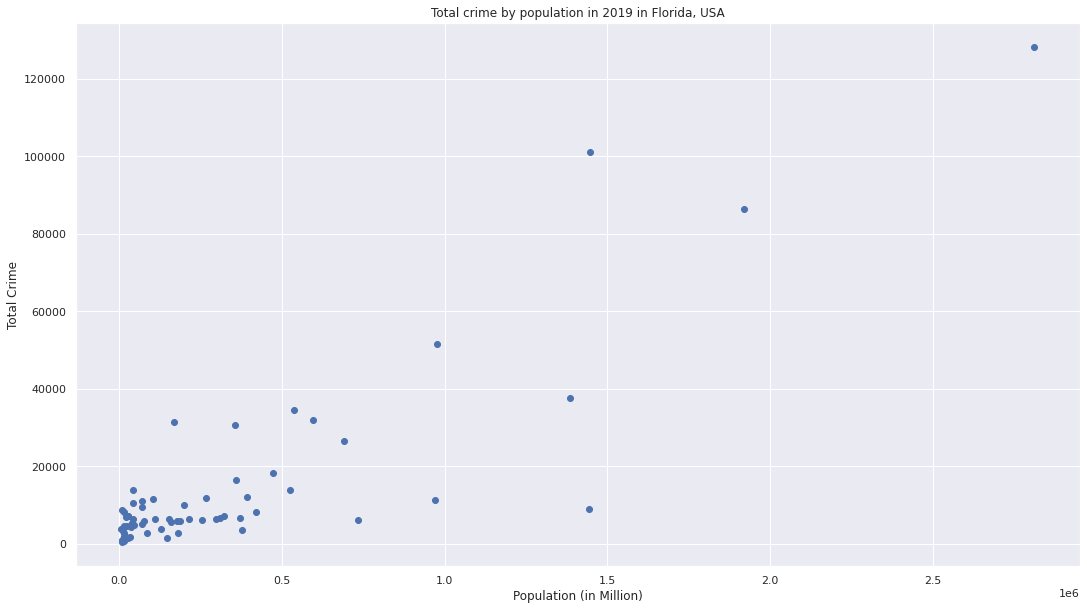

In [56]:
plt.scatter(df_fl_allcrime_grouped['Population'], df_fl_allcrime_grouped['Crime Rate per 100,000 Population'])

plt.ylabel('Total Crime')
plt.xlabel('Population (in Million)')
plt.title('Total crime by population in 2019 in Florida, USA')

plt.show()

This scatter plot showing that the crime rate is increasing exponencially with the population. But we need to take look in details that what type of crime is more common and how they are related to the population. So lets break it down to the type of the crime. 

In [57]:
df_tot_pop = df_fl_allcrime_grouped['Population'].sum()
print(df_tot_pop)

21154970.0


In [58]:
df_fl_allcrime_grouped / df_tot_pop * 100

Population  Total Index Crimes  \
County Name                                         
Alachua County       1.263561            0.042590   
Baker County         0.133534            0.001872   
Bay County           0.790750            0.030882   
Bradford County      0.135580            0.002623   
Brevard County       2.810068            0.068509   
...                       ...                 ...   
Union County         0.073292            0.000615   
Volusia County       2.546461            0.060170   
Wakulla County       0.155878            0.002737   
Walton County        0.331227            0.005134   
Washington County    0.120005            0.001456   

                   Crime Rate per 100,000 Population    Murder     Rape^  \
County Name                                                                
Alachua County                              0.055958  0.000028  0.001333   
Baker County                                0.006626  0.000000  0.000066   
Bay County                                  0.148939  0.000038  0.000430   
Bradford County                             0.034222  0.000005  0.000057   
Brevard County                              0.150942  0.000109  0.001238   
...                                              ...       ...       ...   
Union County                                0.003963  0.000000  0.000057   
Volusia County                              0.163221  0.000118  0.000463   
Wakulla County                              0.008286  0.000000  0.000052   
Walton County                               0.024597  0.000005  0.000085   
Washington County                           0.022233  0.000000  0.000009   

                    Robbery  Aggravated Assault^^  Burglary   Larceny  \
County Name                                                             
Alachua County     0.001385              0.005597  0.004765  0.026675   
Baker County       0.000033              0.000473  0.000298  0.000856   
Bay County         0.000487              0.002950  0.005186  0.019565   
Bradford County    0.000028              0.000440  0.000463  0.001470   
Brevard County     0.001569              0.007596  0.009544  0.044065   
...                     ...                   ...       ...       ...   
Union County       0.000014              0.000151  0.000142  0.000222   
Volusia County     0.001314              0.007143  0.008026  0.039149   
Wakulla County     0.000009              0.000298  0.000586  0.001636   
Walton County      0.000019              0.000567  0.000723  0.003370   
Washington County  0.000028              0.000251  0.000269  0.000766   

                   Motor Vehicle Theft  
County Name                             
Alachua County                0.002808  
Baker County                  0.000147  
Bay County                    0.002226  
Bradford County               0.000161  
Brevard County                0.004387  
...                                ...  
Union County                  0.000028  
Volusia County                0.003957  
Wakulla County                0.000156  
Walton County                 0.000364  
Washington County             0.000132  

[67 rows x 10 columns]

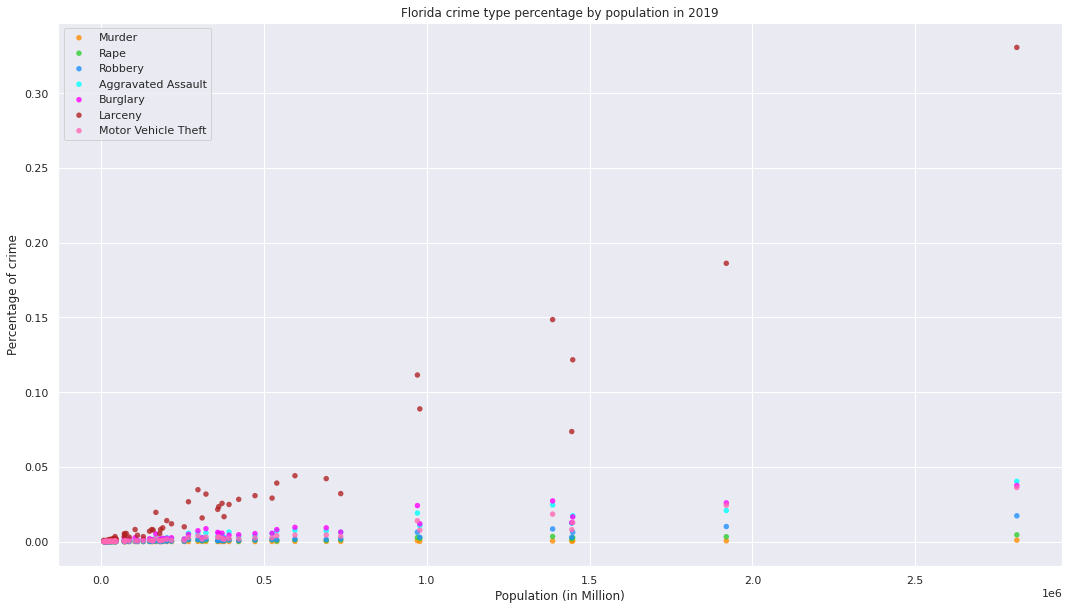

In [59]:
g1 = (df_fl_allcrime_grouped['Population'], df_fl_allcrime_grouped['Murder'] / df_tot_pop * 100)
g2 = (df_fl_allcrime_grouped['Population'], df_fl_allcrime_grouped['Rape^'] / df_tot_pop * 100)
g3 = (df_fl_allcrime_grouped['Population'], df_fl_allcrime_grouped['Robbery'] / df_tot_pop * 100)
g4 = (df_fl_allcrime_grouped['Population'], df_fl_allcrime_grouped['Aggravated Assault^^'] / df_tot_pop * 100)
g5 = (df_fl_allcrime_grouped['Population'], df_fl_allcrime_grouped['Burglary'] / df_tot_pop * 100)
g6 = (df_fl_allcrime_grouped['Population'], df_fl_allcrime_grouped['Larceny'] / df_tot_pop * 100)
g7 = (df_fl_allcrime_grouped['Population'], df_fl_allcrime_grouped['Motor Vehicle Theft'] / df_tot_pop * 100)

data = (g1, g2, g3, g4, g5, g6, g7)
colors = ("darkorange", "limegreen", "dodgerblue", "aqua", "magenta", "firebrick", "hotpink")
groups = ("Murder", "Rape", "Robbery","Aggravated Assault", "Burglary", "Larceny", "Motor Vehicle Theft")

# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Florida crime type percentage by population in 2019')
plt.legend(loc=2)
plt.xlabel('Population (in Million)')
plt.ylabel('Percentage of crime')
plt.show()

Ok .. it's giving a better insight now. So it looks like Larceny is the only crime increasing exponencially with population, though other crimes also increased with population but not much in number compare to Larceny. Now lets have a look at the crime number by County. 

By County we will be checking the crime percentage by County population, and will put them in order by crime percentage and will visualize them in a bar chart.

In [60]:
df_fl_allcrime_grouped_perc = df_fl_allcrime_grouped / df_tot_pop * 100
df_fl_allcrime_grouped_perc['Total Index Crimes'] = df_fl_allcrime_grouped['Total Index Crimes']
df_fl_allcrime_grouped_perc.sort_values('Total Index Crimes', inplace = True)
df_fl_allcrime_grouped_perc

Population  Total Index Crimes  \
County Name                                         
Lafayette County     0.040095                50.0   
Liberty County       0.041465                85.0   
Union County         0.073292               130.0   
Glades County        0.062023               149.0   
Calhoun County       0.066495               150.0   
...                       ...                 ...   
Palm beach County    6.844051             37571.0   
Duval County         4.588388             37710.0   
Orange County        6.552030             48850.0   
Broward County       9.074199             57348.0   
Miami County        13.292999             98880.0   

                   Crime Rate per 100,000 Population    Murder     Rape^  \
County Name                                                                
Lafayette County                            0.002787  0.000000  0.000005   
Liberty County                              0.004580  0.000005  0.000000   
Union County                                0.003963  0.000000  0.000057   
Glades County                               0.005332  0.000000  0.000009   
Calhoun County                              0.012809  0.000005  0.000000   
...                                              ...       ...       ...   
Palm beach County                           0.477779  0.000411  0.002652   
Duval County                                0.054085  0.000619  0.002761   
Orange County                               0.177443  0.000430  0.003394   
Broward County                              0.408700  0.000525  0.003252   
Miami County                                0.605233  0.000955  0.004514   

                    Robbery  Aggravated Assault^^  Burglary   Larceny  \
County Name                                                             
Lafayette County   0.000000              0.000057  0.000057  0.000095   
Liberty County     0.000005              0.000080  0.000104  0.000165   
Union County       0.000014              0.000151  0.000142  0.000222   
Glades County      0.000000              0.000104  0.000095  0.000440   
Calhoun County     0.000005              0.000161  0.000165  0.000307   
...                     ...                   ...       ...       ...   
Palm beach County  0.006259              0.017353  0.016511  0.121645   
Duval County       0.006292              0.019102  0.024089  0.111468   
Orange County      0.008457              0.024486  0.027213  0.148547   
Broward County     0.010087              0.020789  0.025904  0.186212   
Miami County       0.017249              0.040326  0.037514  0.330665   

                   Motor Vehicle Theft  
County Name                             
Lafayette County              0.000024  
Liberty County                0.000043  
Union County                  0.000028  
Glades County                 0.000057  
Calhoun County                0.000066  
...                                ...  
Palm beach County             0.012768  
Duval County                  0.013926  
Orange County                 0.018388  
Broward County                0.024316  
Miami County                  0.036185  

[67 rows x 10 columns]

In [61]:
N = df_fl_allcrime_grouped_perc.shape[0]
width = 0.6
ind = np.arange(N) 

In [62]:
df_fl_crime_barplot = df_fl_allcrime_grouped_perc[['Rape^','Murder','Robbery','Aggravated Assault^^','Burglary','Motor Vehicle Theft','Larceny']]
df_fl_crime_barplot

Rape^    Murder   Robbery  Aggravated Assault^^  \
County Name                                                             
Lafayette County   0.000005  0.000000  0.000000              0.000057   
Liberty County     0.000000  0.000005  0.000005              0.000080   
Union County       0.000057  0.000000  0.000014              0.000151   
Glades County      0.000009  0.000000  0.000000              0.000104   
Calhoun County     0.000000  0.000005  0.000005              0.000161   
...                     ...       ...       ...                   ...   
Palm beach County  0.002652  0.000411  0.006259              0.017353   
Duval County       0.002761  0.000619  0.006292              0.019102   
Orange County      0.003394  0.000430  0.008457              0.024486   
Broward County     0.003252  0.000525  0.010087              0.020789   
Miami County       0.004514  0.000955  0.017249              0.040326   

                   Burglary  Motor Vehicle Theft   Larceny  
County Name                                                 
Lafayette County   0.000057             0.000024  0.000095  
Liberty County     0.000104             0.000043  0.000165  
Union County       0.000142             0.000028  0.000222  
Glades County      0.000095             0.000057  0.000440  
Calhoun County     0.000165             0.000066  0.000307  
...                     ...                  ...       ...  
Palm beach County  0.016511             0.012768  0.121645  
Duval County       0.024089             0.013926  0.111468  
Orange County      0.027213             0.018388  0.148547  
Broward County     0.025904             0.024316  0.186212  
Miami County       0.037514             0.036185  0.330665  

[67 rows x 7 columns]

<function matplotlib.pyplot.show(*args, **kw)>

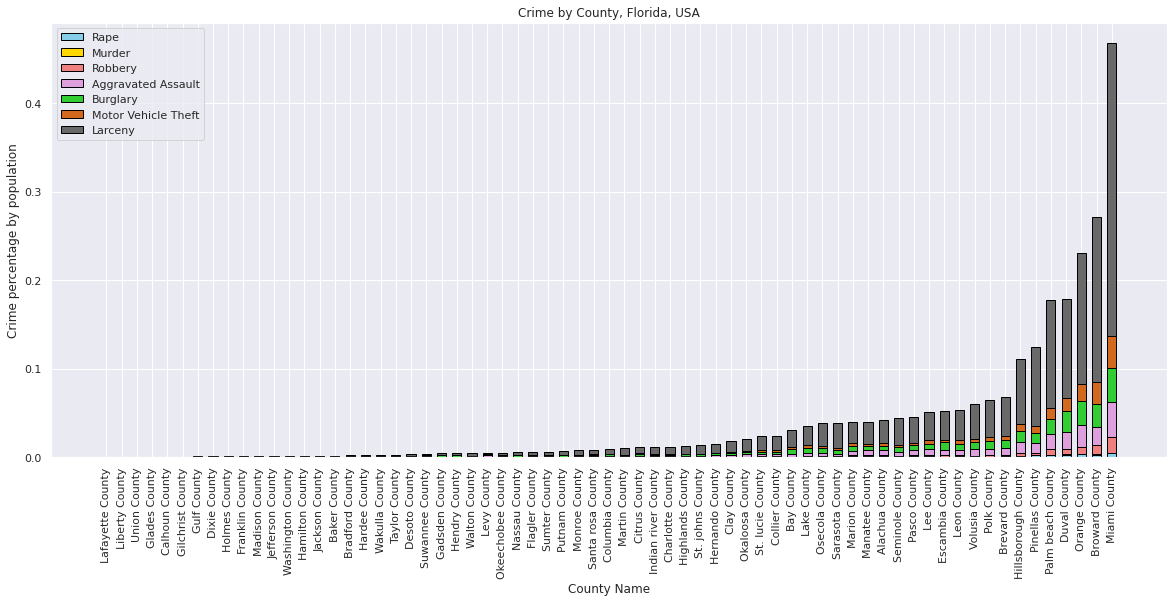

In [63]:
col_nm = [name.replace("^", "") for name in df_fl_crime_barplot.columns.values]
color = ['skyblue','gold','lightcoral','plum','limegreen','chocolate','dimgrey']
N = df_fl_crime_barplot.shape[1]
width = 0.6
ind = np.arange(df_fl_crime_barplot.shape[0])
bottom = df_fl_crime_barplot.iloc[:, 0]

plt.figure(figsize=(20, 8)) 

for num in np.arange(N):
    if num == 0:
        plt.bar(ind, df_fl_crime_barplot.iloc[:, num], width = width, color= color[num], align='center', edgecolor = 'black')
    else:
        plt.bar(ind, df_fl_crime_barplot.iloc[:, num], bottom = bottom, width = width, color= color[num], align='center', edgecolor = 'black')
        bottom = tuple(map(lambda i, j: i + j, bottom, df_fl_crime_barplot.iloc[:, num]))

plt.legend(labels = col_nm)
plt.ylabel('Crime percentage by population')
plt.xlabel('County Name')
plt.title('Crime by County, Florida, USA')
plt.xticks(ind, df_fl_allcrime_grouped_perc.index.values, rotation=90)
plt.show

Now we have a good understanding of the crime rate, type by County and by population. Miami being the most populated County having higher crime rate in most of the categories but Larceny is exceptionally high, but other Countys like Broward, Orange, Duval also highly populated but crime rate is lower compare to Miami.

#### Housing price Index

Now lets have a look at the housing price index by County. Lets first have a look how the HPI has changed by County over the last 10 years. To get a better visual we will put it in a boxplot.

In [64]:
df_fl_hpi = df_all_hpi[df_all_hpi['State'] == 'FL'][['County','Year','Annual Change (%)', 'HPI']]
df_fl_hpi.replace('.',np.NaN, inplace = True)
df_fl_hpi[['Annual Change (%)', 'HPI']] = df_fl_hpi[['Annual Change (%)', 'HPI']].apply(pd.to_numeric)
df_fl_hpi.dtypes

County                object
Year                   int64
Annual Change (%)    float64
HPI                  float64
dtype: object

In [65]:
import seaborn as sns

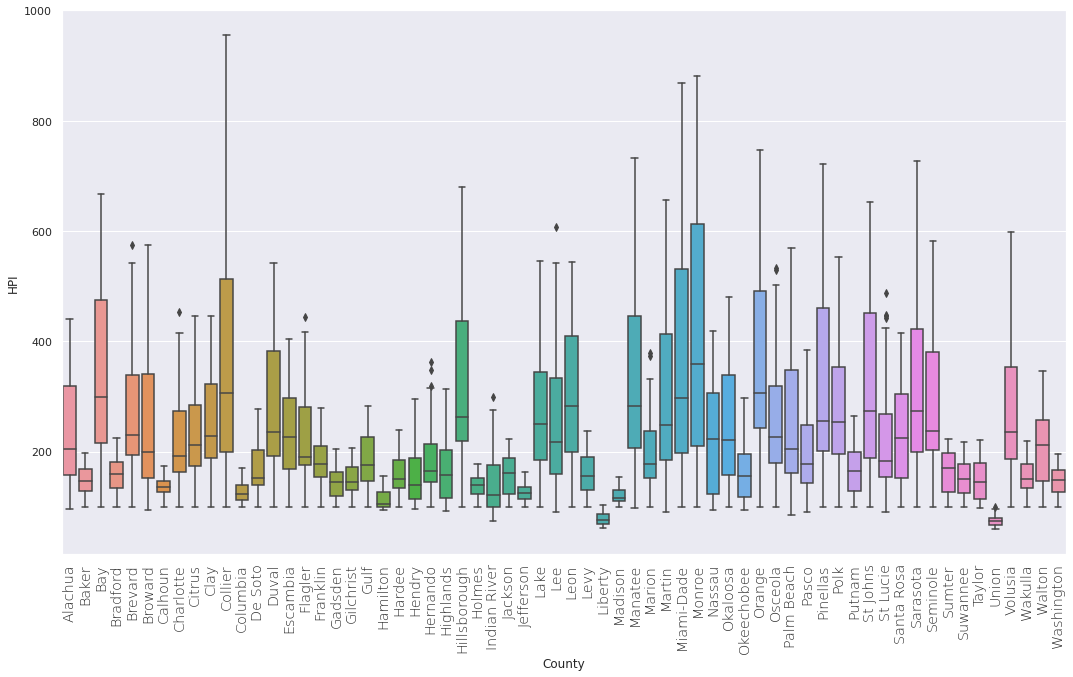

In [66]:
sns.set(rc={'figure.figsize':(18,10)})
ax = sns.boxplot(x="County", y="HPI", data=df_fl_hpi)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontweight='light', fontsize='large')
None



Now lets compare the housing price index by population by County. We will also break down the population to different age group people to see if it provides any valuable insight.

Finally we will visualize the data in bar and line chart.

In [67]:
df_fl_hpi_2019 = df_fl_hpi[df_fl_hpi['Year'] == 2019][['County','Annual Change (%)','HPI']]
df_fl_hpi_2019['County'] = df_fl_hpi_2019['County'] + " County"
df_fl_hpi_2019

County  Annual Change (%)     HPI
9452      Alachua County               5.12  432.11
9474        Baker County               4.73  193.17
9519          Bay County               8.66  644.54
9543     Bradford County               3.45  202.29
9587      Brevard County               5.08  541.83
...                  ...                ...     ...
11525       Union County               2.52   79.61
11570     Volusia County               6.44  565.97
11595     Wakulla County               5.54  187.58
11623      Walton County               7.75  317.21
11645  Washington County              18.03  191.59

[64 rows x 3 columns]

In [68]:
df_fl_hpi_pop = df_fl_hpi_2019.set_index('County').join(df_fl_agepop.set_index('CTYNAME'))
df_fl_hpi_pop

Annual Change (%)     HPI  POPESTIMATE  UNDER5_TOT  \
County                                                                  
Alachua County                  5.12  432.11     269043.0     13818.0   
Baker County                    4.73  193.17      29210.0      1810.0   
Bay County                      8.66  644.54     174705.0      9997.0   
Bradford County                 3.45  202.29      28201.0      1482.0   
Brevard County                  5.08  541.83     601942.0     27397.0   
...                              ...     ...          ...         ...   
Union County                    2.52   79.61      15237.0       795.0   
Volusia County                  6.44  565.97     553284.0     25844.0   
Wakulla County                  5.54  187.58      33739.0      1759.0   
Walton County                   7.75  317.21      74071.0      4141.0   
Washington County              18.03  191.59      25473.0      1323.0   

                   AGE513_TOT  AGE1417_TOT  AGE1824_TOT  AGE2544_TOT  \
County                                                                 
Alachua County        24490.0       9981.0      54974.0      71869.0   
Baker County           3592.0       1569.0       2374.0       8238.0   
Bay County            18144.0       7842.0      12978.0      44883.0   
Bradford County        2776.0       1213.0       2251.0       8207.0   
Brevard County        55537.0      26221.0      42515.0     132120.0   
...                       ...          ...          ...          ...   
Union County           1548.0        669.0       1294.0       4347.0   
Volusia County        48951.0      21981.0      44000.0     123446.0   
Wakulla County         3492.0       1737.0       2335.0       9395.0   
Walton County          7715.0       3228.0       4487.0      18073.0   
Washington County      2569.0       1183.0       2163.0       6844.0   

                   AGE4564_TOT  AGE65PLUS_TOT  
County                                         
Alachua County         54639.0        39272.0  
Baker County            7510.0         4117.0  
Bay County             48326.0        32535.0  
Bradford County         7208.0         5064.0  
Brevard County        172400.0       145752.0  
...                        ...            ...  
Union County            4267.0         2317.0  
Volusia County        151251.0       137811.0  
Wakulla County          9655.0         5366.0  
Walton County          21450.0        14977.0  
Washington County       7011.0         4380.0  

[64 rows x 10 columns]

In [69]:
from sklearn.preprocessing import StandardScaler

X = df_fl_hpi_pop.values[:,0:]
X = np.nan_to_num(X)
df1 = StandardScaler().fit_transform(X)
df = pd.DataFrame(df1)
df.columns = df_fl_hpi_pop.columns
df = df+3
df.insert(loc=0, column='County Name', value=df_fl_hpi_pop.index.values)
df.describe()

Annual Change (%)        HPI  POPESTIMATE  UNDER5_TOT  AGE513_TOT  \
count          64.000000  64.000000    64.000000   64.000000   64.000000   
mean            3.000000   3.000000     3.000000    3.000000    3.000000   
std             1.007905   1.007905     1.007905    1.007905    1.007905   
min             0.065814   1.165504     2.360198    2.406382    2.382972   
25%             2.594440   2.120685     2.415072    2.464373    2.446464   
50%             2.874823   2.952639     2.603725    2.562533    2.564651   
75%             3.433647   3.738995     3.104138    3.026645    3.043914   
max             7.126542   5.298876     7.706846    7.802309    7.575054   

       AGE1417_TOT  AGE1824_TOT  AGE2544_TOT  AGE4564_TOT  AGE65PLUS_TOT  
count    64.000000    64.000000    64.000000    64.000000      64.000000  
mean      3.000000     3.000000     3.000000     3.000000       3.000000  
std       1.007905     1.007905     1.007905     1.007905       1.007905  
min       2.378617     2.379056     2.411911     2.372133       2.275939  
25%       2.440169     2.433317     2.468344     2.425130       2.325571  
50%       2.571831     2.537220     2.560537     2.587636       2.632832  
75%       3.049195     3.202148     2.994321     3.068635       3.355597  
max       7.591358     7.659157     7.808877     7.829663       7.104208

In [70]:
df.sort_values('POPESTIMATE', ascending = False)[['UNDER5_TOT','AGE513_TOT','AGE1417_TOT','AGE1824_TOT','AGE2544_TOT','AGE4564_TOT','AGE65PLUS_TOT']]

UNDER5_TOT  AGE513_TOT  AGE1417_TOT  AGE1824_TOT  AGE2544_TOT  \
39    7.802309    7.575054     7.591358     7.659157     7.808877   
5     6.251884    6.327431     6.339891     5.912388     6.168147   
46    5.025017    5.097899     5.201493     4.986782     4.923587   
25    5.459083    5.540578     5.446502     5.424764     5.488936   
44    5.289856    5.329444     5.303408     5.723107     5.531831   
..         ...         ...          ...          ...          ...   
16    2.423953    2.401025     2.396332     2.397956     2.434954   
34    2.418943    2.396579     2.394745     2.395025     2.431582   
12    2.406382    2.382972     2.378617     2.379056     2.411911   
52    2.406382    2.382972     2.378617     2.379056     2.411911   
51    2.406382    2.382972     2.378617     2.379056     2.411911   

    AGE4564_TOT  AGE65PLUS_TOT  
39     7.829663       7.104208  
5      6.323111       5.845304  
46     5.238132       6.164780  
25     5.140160       4.559197  
44     4.877677       4.106055  
..          ...            ...  
16     2.396667       2.307153  
34     2.388590       2.289338  
12     2.372133       2.275939  
52     2.372133       2.275939  
51     2.372133       2.275939  

[64 rows x 7 columns]

<function matplotlib.pyplot.show(*args, **kw)>

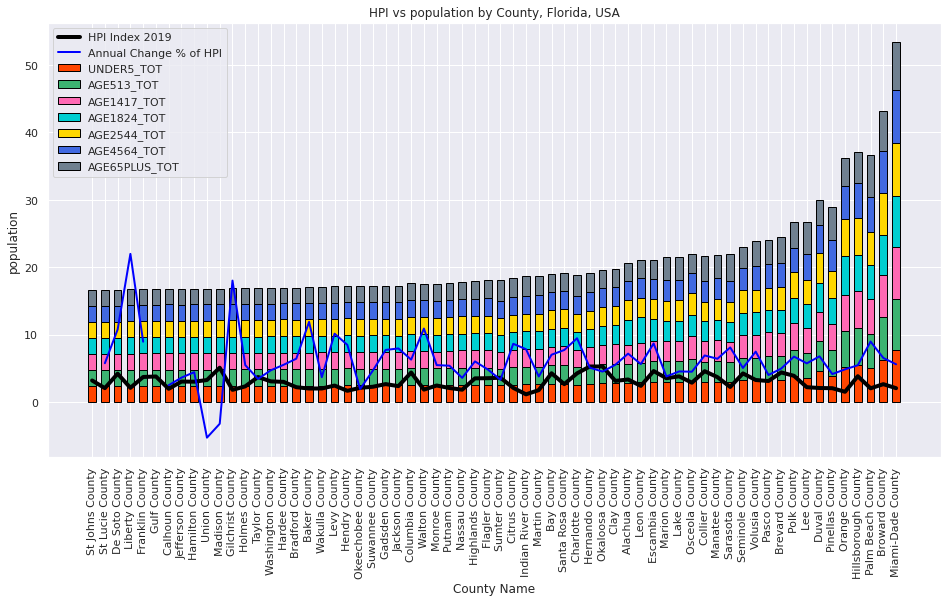

In [71]:
col_nm = ['UNDER5_TOT','AGE513_TOT','AGE1417_TOT','AGE1824_TOT','AGE2544_TOT','AGE4564_TOT','AGE65PLUS_TOT']
df_plot01 = df.sort_values('POPESTIMATE')
df_plot1 = df_plot01[col_nm]
#print(df_plot1)

color = ['orangered','mediumseagreen','hotpink','darkturquoise','gold','royalblue','slategray']
N = len(col_nm)

width = 0.6
ind = np.arange(df_plot1.shape[0])
#ind = np.arange(1)

plt.figure(figsize=(16, 8)) 
bottom = df_plot1.iloc[:, 0]

for num in np.arange(N):
    if num == 0:
        plt.bar(ind, df_plot1.iloc[:, num], width = width, color = color[num], align = 'center', edgecolor = 'black')
    else:
        plt.bar(ind, df_plot1.iloc[:, num], bottom = bottom, width = width, color = color[num], align='center', edgecolor = 'black')
        bottom = tuple(map(lambda i, j: i + j, bottom, df_plot1.iloc[:, num]))

plt.plot(ind, df['HPI'], linewidth=4, color = 'black')
plt.plot(ind, df_fl_hpi_pop.sort_values('POPESTIMATE')['Annual Change (%)'], linewidth=2, color = 'blue')

df_legend = col_nm
df_legend.insert(0, 'Annual Change % of HPI')
df_legend.insert(0, 'HPI Index 2019')

plt.legend(labels = df_legend)
plt.ylabel('population')
plt.xlabel('County Name')
plt.title('HPI vs population by County, Florida, USA')
plt.xticks(ind, df_plot01['County Name'], rotation=90)
plt.show

Here we are checking HPI for the year 2019 only, and the blue line represent the HPI change percentage from the year 2018 to 2019. We have here also breakdown the population by different age group. 

So it looks like different age group people has almost equal percentage by population, so age group details may not help to draw conclusion in this analysis. So will exclude this details from our analysis.


Now lets have a look at the house sale price in different category by County. We will mostly look at the price from year 2019.

In [72]:
df_fl_hprice_sf = df_fl_housedata[(df_fl_housedata['Characteristic'] == 'Mean assessed value')][['Geography','Single Family']]
df_fl_hprice_sf.columns = ['County Name', 'Mean assessed value']
df_fl_hprice_sf.reset_index(drop = True, inplace = True)
df_fl_hprice_sf['Mean just value'] = df_fl_housedata[(df_fl_housedata['Characteristic'] == 'Mean just value')]['Single Family'].reset_index(drop = True)
df_fl_hprice_sf['2019 Mean Sales Price'] = df_fl_housedata[(df_fl_housedata['Characteristic'] == '2019 Mean Sales Price')]['Single Family'].reset_index(drop = True)
df_fl_hprice_sf['2019 25th Percentile Sales Price'] = df_fl_housedata[(df_fl_housedata['Characteristic'] == '2019 25th Percentile Sales Price')]['Single Family'].reset_index(drop = True)
df_fl_hprice_sf['2019 75th Percentile Sales Price'] = df_fl_housedata[(df_fl_housedata['Characteristic'] == '2019 75th Percentile Sales Price')]['Single Family'].reset_index(drop = True)
df_fl_hprice_sf

County Name  Mean assessed value  Mean just value  \
0      Alachua County               155034           177826   
1        Baker County               121630           139243   
2          Bay County               147369           153453   
3     Bradford County                97165           103149   
4      Brevard County               160411           211056   
..                ...                  ...              ...   
62       Union County                82273            86789   
63     Volusia County               150299           193924   
64     Wakulla County               124605           148571   
65      Walton County               466404           493477   
66  Washington County                80168            82623   

    2019 Mean Sales Price  2019 25th Percentile Sales Price  \
0                  244426                            158000   
1                  192400                            184900   
2                  230151                            135000   
3                  177273                            114700   
4                  266566                            169800   
..                    ...                               ...   
62                 162415                            135000   
63                 243897                            164900   
64                 192513                            125000   
65                 756236                            298000   
66                 142079                             84400   

    2019 75th Percentile Sales Price  
0                             290000  
1                             199900  
2                             280000  
3                             212000  
4                             315000  
..                               ...  
62                            175750  
63                            278000  
64                            240000  
65                            825000  
66                            187500  

[67 rows x 6 columns]

[Text(0, 0, 'Alachua County'),
 Text(0, 0, 'Baker County'),
 Text(0, 0, 'Bay County'),
 Text(0, 0, 'Bradford County'),
 Text(0, 0, 'Brevard County'),
 Text(0, 0, 'Broward County'),
 Text(0, 0, 'Calhoun County'),
 Text(0, 0, 'Charlotte County'),
 Text(0, 0, 'Citrus County'),
 Text(0, 0, 'Clay County'),
 Text(0, 0, 'Collier County'),
 Text(0, 0, 'Columbia County'),
 Text(0, 0, 'DeSoto County'),
 Text(0, 0, 'Dixie County'),
 Text(0, 0, 'Duval County'),
 Text(0, 0, 'Escambia County'),
 Text(0, 0, 'Flagler County'),
 Text(0, 0, 'Franklin County'),
 Text(0, 0, 'Gadsden County'),
 Text(0, 0, 'Gilchrist County'),
 Text(0, 0, 'Glades County'),
 Text(0, 0, 'Gulf County'),
 Text(0, 0, 'Hamilton County'),
 Text(0, 0, 'Hardee County'),
 Text(0, 0, 'Hendry County'),
 Text(0, 0, 'Hernando County'),
 Text(0, 0, 'Highlands County'),
 Text(0, 0, 'Hillsborough County'),
 Text(0, 0, 'Holmes County'),
 Text(0, 0, 'Indian River County'),
 Text(0, 0, 'Jackson County'),
 Text(0, 0, 'Jefferson County'),
 Text(

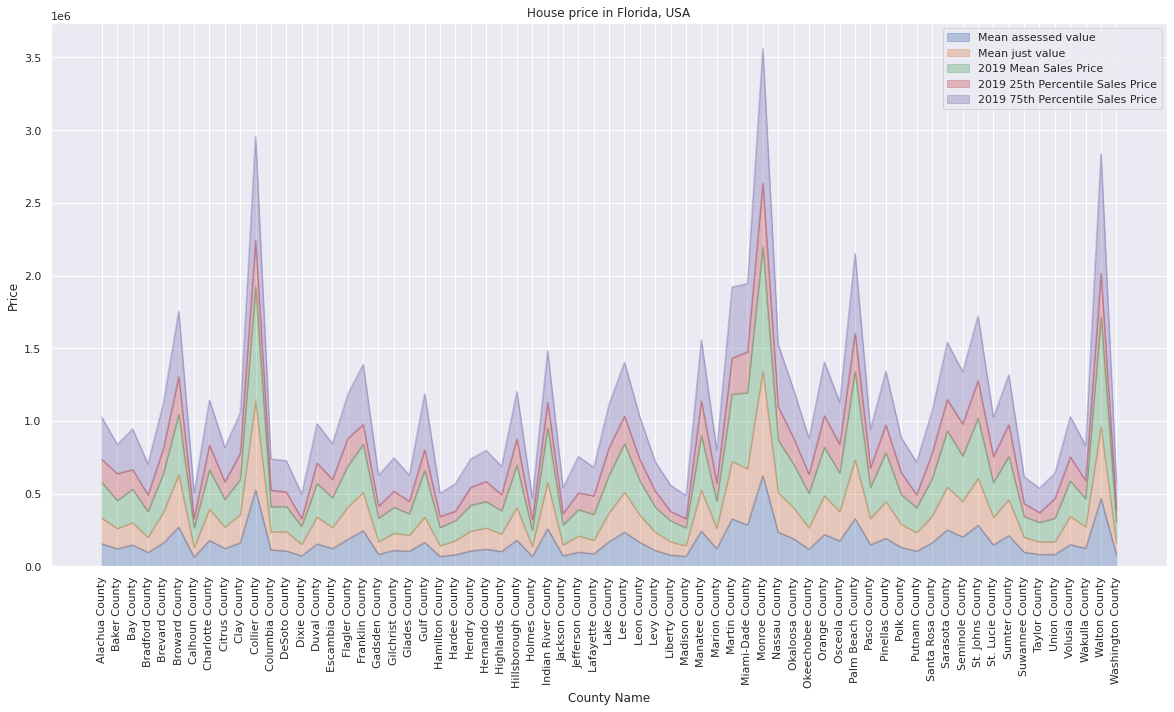

In [73]:
ax = df_fl_hprice_sf.plot(kind='area', alpha=0.35, figsize=(20, 10))

ax.set_title('House price in Florida, USA')
ax.set_ylabel('Price')
ax.set_xlabel('County Name')

ax.set_xticks(np.arange(len(df_fl_hprice_sf['County Name'])))
ax.set_xticklabels(df_fl_hprice_sf['County Name'], rotation = 90)

In [74]:
len(df_fl_hprice_sf['County Name'])


67

In [75]:
help(ax.set_xticks)

Help on method set_xticks in module matplotlib.axes._base:

set_xticks(ticks, *, minor=False) method of matplotlib.axes._subplots.AxesSubplot instance
    Set the x ticks with list of *ticks*
    
    Parameters
    ----------
    ticks : list
        List of x-axis tick locations.
    
    minor : bool, optional
        If ``False`` sets major ticks, if ``True`` sets minor ticks.
        Default is ``False``.



In [76]:
df_fl_housedata_all = df_fl_housedata[df_fl_housedata['Characteristic'] == 'Mean just value']
df_fl_housedata_all.drop('Characteristic', axis = 1, inplace = True)
df_fl_housedata_all.reset_index(drop = True, inplace = True)
df_fl_housedata_all.drop(columns=['Multifamily 10 or More Units'], inplace = True)
df_fl_housedata_all

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Geography  Single Family  Mobile Home  Condominium  \
0      Alachua County         177826      59405.0      95480.0   
1        Baker County         139243      63416.0          0.0   
2          Bay County         153453      48217.0     211142.0   
3     Bradford County         103149      49872.0       -100.0   
4      Brevard County         211056      66250.0     168862.0   
..                ...            ...          ...          ...   
62       Union County          86789      45335.0       -100.0   
63     Volusia County         193924      79132.0     216974.0   
64     Wakulla County         148571      53405.0     113245.0   
65      Walton County         493477      35640.0     384452.0   
66  Washington County          82623      40194.0          0.0   

    Multifamily Less than 10 Units  
0                         157064.0  
1                         105765.0  
2                         133793.0  
3                         105217.0  
4                         234854.0  
..                             ...  
62                          -100.0  
63                        186899.0  
64                          -100.0  
65                        188065.0  
66                        116479.0  

[67 rows x 5 columns]

In [77]:
df_ = df_fl_housedata_all.iloc[:, 1:]
df_1 = df_.mask(df_ <= 0)
df_1.insert(0, "County Name", df_fl_housedata_all['Geography'])

#df_1.set_index('County Name', inplace=True)
#df_1
#df_fl_housedata_all.where(df_fl_housedata_all < 0, np.nan)
#df_fl_housedata_all.clip(lower=0)
#df_fl_housedata_all

[Text(0, 0, 'Alachua County'),
 Text(0, 0, 'Baker County'),
 Text(0, 0, 'Bay County'),
 Text(0, 0, 'Bradford County'),
 Text(0, 0, 'Brevard County'),
 Text(0, 0, 'Broward County'),
 Text(0, 0, 'Calhoun County'),
 Text(0, 0, 'Charlotte County'),
 Text(0, 0, 'Citrus County'),
 Text(0, 0, 'Clay County'),
 Text(0, 0, 'Collier County'),
 Text(0, 0, 'Columbia County'),
 Text(0, 0, 'DeSoto County'),
 Text(0, 0, 'Dixie County'),
 Text(0, 0, 'Duval County'),
 Text(0, 0, 'Escambia County'),
 Text(0, 0, 'Flagler County'),
 Text(0, 0, 'Franklin County'),
 Text(0, 0, 'Gadsden County'),
 Text(0, 0, 'Gilchrist County'),
 Text(0, 0, 'Glades County'),
 Text(0, 0, 'Gulf County'),
 Text(0, 0, 'Hamilton County'),
 Text(0, 0, 'Hardee County'),
 Text(0, 0, 'Hendry County'),
 Text(0, 0, 'Hernando County'),
 Text(0, 0, 'Highlands County'),
 Text(0, 0, 'Hillsborough County'),
 Text(0, 0, 'Holmes County'),
 Text(0, 0, 'Indian River County'),
 Text(0, 0, 'Jackson County'),
 Text(0, 0, 'Jefferson County'),
 Text(

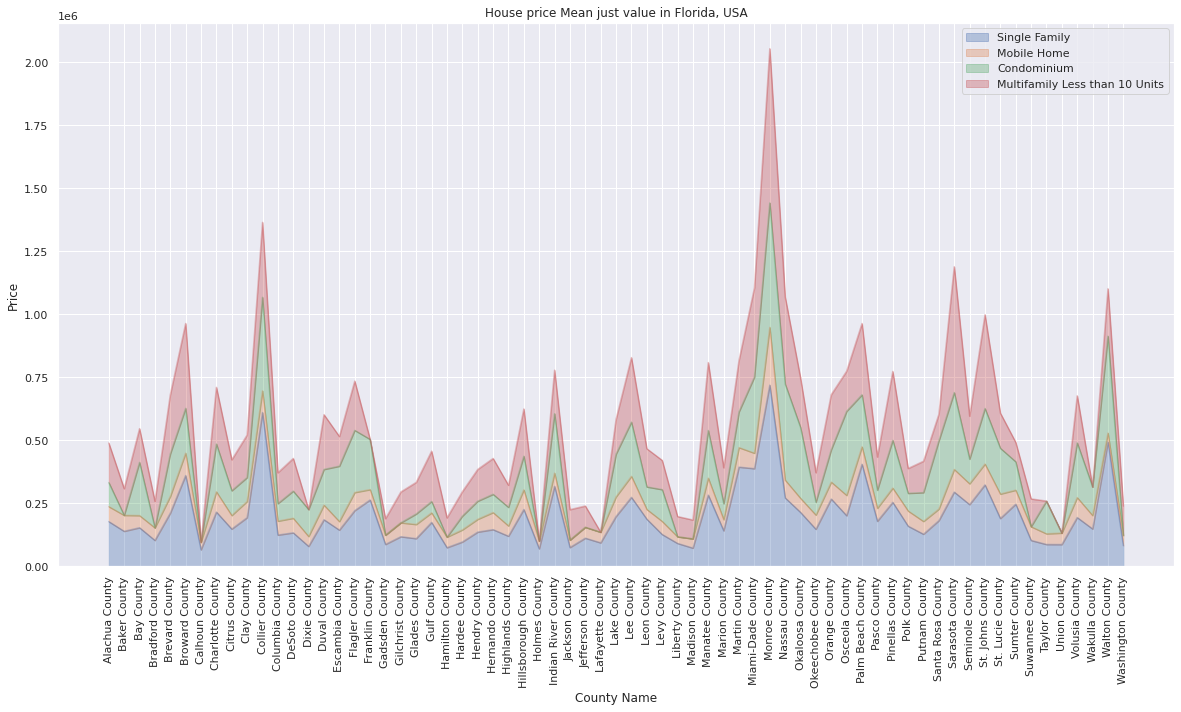

In [78]:
ax = df_1.plot(kind='area', alpha=0.35, figsize=(20, 10))

ax.set_title('House price Mean just value in Florida, USA')
ax.set_ylabel('Price')
ax.set_xlabel('County Name')

ax.set_xticks(np.arange(df_1.shape[0]))
ax.set_xticklabels(df_1['County Name'],rotation = 90)

For investment I think a major parameter to consider is the race. For opening a business we should consider most of the customer belongs to which race based on that take business decision for better growth, for example if someone have a plan to open a Restaurent they can decide on cuisine based on the race of the people in that area, or someone would like to buy house they may want to consider a locality where most people belongs to same race as him/her. 

So in our next phase we will categorize the County based on the population of people from different race. In Florida there are few major race as given below .. and we will see top 10 countys in Florida in each category.

* White American
* Black or African American
* Asian
* Hispanic
* Not Hispanic


In [79]:
race_cols = ['CTYNAME','TOT_MALE','TOT_FEMALE','WA_MALE','WA_FEMALE','BA_MALE','BA_FEMALE','AA_MALE','AA_FEMALE','NH_MALE','NH_FEMALE','H_MALE','H_FEMALE']
df_fl_race = df_fl_agesexrace[(df_fl_agesexrace['AGEGRP'] > 0) & (df_fl_agesexrace['YEAR'] == 12)][race_cols].groupby('CTYNAME').sum()


In [80]:
df_fl_race_WA = df_fl_race[['WA_MALE','WA_FEMALE']]
df_fl_race_WA_top10 = df_fl_race_WA.assign(WA_Total = (df_fl_race['WA_MALE'] + df_fl_race['WA_FEMALE'])) \
    .sort_values('WA_Total', ascending = False) \
    .head(20) \
    .reset_index()
#df_fl_race_WA_top10

df_fl_race_BA = df_fl_race[['BA_MALE','BA_FEMALE']]
df_fl_race_BA_top10 = df_fl_race_BA.assign(BA_Total = (df_fl_race['BA_MALE'] + df_fl_race['BA_FEMALE'])) \
    .sort_values('BA_Total', ascending = False) \
    .head(20) \
    .reset_index()

#df_fl_race_BA_top10

df_fl_race_AA = df_fl_race[['AA_MALE','AA_FEMALE']]
df_fl_race_AA_top10 = df_fl_race_AA.assign(AA_Total = (df_fl_race['AA_MALE'] + df_fl_race['AA_FEMALE'])) \
    .sort_values('AA_Total', ascending = False) \
    .head(20) \
    .reset_index()
#df_fl_race_AA_top10

df_fl_race_NH = df_fl_race[['NH_MALE','NH_FEMALE']]
df_fl_race_NH_top10 = df_fl_race_NH.assign(NH_Total = (df_fl_race['NH_MALE'] + df_fl_race['NH_FEMALE'])) \
    .sort_values('NH_Total', ascending = False) \
    .head(20) \
    .reset_index()
df_fl_race_NH_top10

df_fl_race_H = df_fl_race[['H_MALE','H_FEMALE']]
df_fl_race_H_top10 = df_fl_race_H.assign(H_Total = (df_fl_race['H_MALE'] + df_fl_race['H_FEMALE'])) \
    .sort_values('H_Total', ascending = False) \
    .head(20) \
    .reset_index()

df_fl_tot = df_fl_race[['TOT_MALE','TOT_FEMALE']]
df_fl_tot_top10 = df_fl_tot.assign(Total = (df_fl_tot['TOT_MALE'] + df_fl_tot['TOT_FEMALE'])) \
    .sort_values('Total', ascending = False) \
    .head(20) \
    .reset_index()

Now lets visualize it in bar chart, here we will be viewing top 10 most populated county by each race.

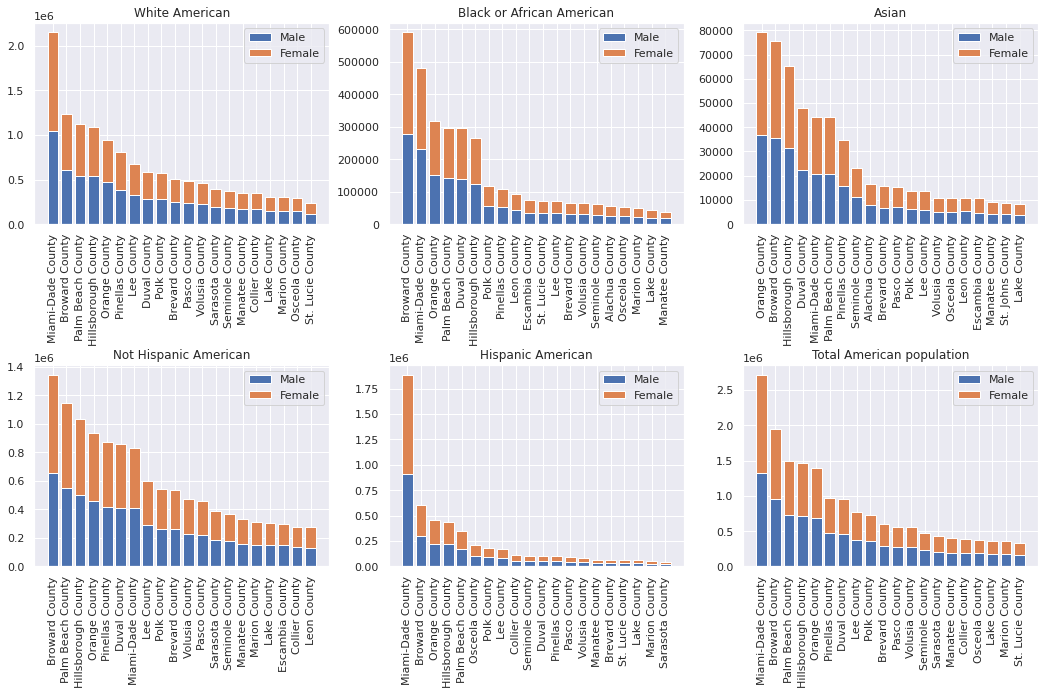

In [81]:
fig, axs = plt.subplots(2, 3)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.7)
axs[0, 0].bar(df_fl_race_WA_top10['CTYNAME'], df_fl_race_WA_top10['WA_MALE'])
axs[0, 0].bar(df_fl_race_WA_top10['CTYNAME'], df_fl_race_WA_top10['WA_FEMALE'], bottom = df_fl_race_WA_top10['WA_MALE'])
axs[0, 0].set_title('White American')
axs[0, 1].bar(df_fl_race_BA_top10['CTYNAME'], df_fl_race_BA_top10['BA_MALE'])
axs[0, 1].bar(df_fl_race_BA_top10['CTYNAME'], df_fl_race_BA_top10['BA_FEMALE'], bottom = df_fl_race_BA_top10['BA_MALE'])
axs[0, 1].set_title('Black or African American')
axs[0, 2].bar(df_fl_race_AA_top10['CTYNAME'], df_fl_race_AA_top10['AA_MALE'])
axs[0, 2].bar(df_fl_race_AA_top10['CTYNAME'], df_fl_race_AA_top10['AA_FEMALE'], bottom = df_fl_race_AA_top10['AA_MALE'])
axs[0, 2].set_title('Asian')
axs[1, 0].bar(df_fl_race_NH_top10['CTYNAME'], df_fl_race_NH_top10['NH_MALE'])
axs[1, 0].bar(df_fl_race_NH_top10['CTYNAME'], df_fl_race_NH_top10['NH_FEMALE'], bottom = df_fl_race_NH_top10['NH_MALE'])
axs[1, 0].set_title('Not Hispanic American')
axs[1, 1].bar(df_fl_race_H_top10['CTYNAME'], df_fl_race_H_top10['H_MALE'])
axs[1, 1].bar(df_fl_race_H_top10['CTYNAME'], df_fl_race_H_top10['H_FEMALE'], bottom = df_fl_race_H_top10['H_MALE'])
axs[1, 1].set_title('Hispanic American')
axs[1, 2].bar(df_fl_tot_top10['CTYNAME'], df_fl_tot_top10['TOT_MALE'])
axs[1, 2].bar(df_fl_tot_top10['CTYNAME'], df_fl_tot_top10['TOT_FEMALE'], bottom = df_fl_tot_top10['TOT_MALE'])
axs[1, 2].set_title('Total American population')

for x in np.arange(2):
    for y in np.arange(3):
        for tick in axs[x, y].get_xticklabels():
            tick.set_rotation(90)
        axs[x, y].legend(labels = ['Male','Female'])

Ok .. now lets check the Venue avaialable in each county. Here we will use Google Maps to find venue in each county. We will check all the category type defined in Google nearby places api and will check the most common venues in each county. There are few limitation with Google map api we need to remember. Google map api return a page with max 20 items, and at max it will return only 3 pages. There will be a next page token in each page which need to get the next page and the next may not be avaiable immediately so we need to put some wait before calling the next page. We will take care these scenarios in our code.

To start with lets first install the googlemaps package.

In [82]:
!pip install googlemaps

In [83]:
import googlemaps
import pprint
import numpy as np
import time
import pandas as pd
import traceback

In [43]:
#from GoogleMapsAPIKey import get_my_key
API_key = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
gmaps = googlemaps.Client(key = API_key)

Now lets write a function to go through each page, and this function will take a Dataframe as parameter to append the result and then finaly will return the same dataframe after appending the venue details fetched from the api.

In [44]:
dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])

#def get_ven_attr(ven, df, cols):
    

def get_ven_by_catg(df, cols, catg, lat, lon, pno = 1, page_token = ""):

    if page_token == "":
        #print("First Page")
        ven = gmaps.places_nearby(location=[lat, lon], radius=90000, type=catg)
    else:
        #print("Checking page " + str(pno))
        #print(page_token)
        ven = gmaps.places_nearby(page_token = page_token)
 
    #print(ven)
    for row in ven['results']:
        #print(dictfilt(row, cols))
        r = dictfilt(row, cols)
        #print(r)
        df = df.append(pd.DataFrame.from_dict(r), ignore_index=True)
        #df = df.append(pd.DataFrame.from_dict(r, orient = 'index').T, ignore_index=True)
        #print(df)
    #print("------------------------------------------------------------------------")
    
    try :
        nexttoken = ven['next_page_token']
        #print(nexttoken)
        time.sleep(2)
        #print("Calling next page")
        get_ven_by_catg(df, cols, catg, lat, lon, pno + 1, page_token = nexttoken)
    except Exception:
        #traceback.print_exc()
        print("Total " + str(pno) + " page checked for Category " + catg)
    
    return df

Below function to go through each venue type defined in Google map api and then call the previous function to call the api to get detail for that particular category.

In [119]:
def get_all_ven(lat, lon):
    cols = ('name','types','rating','user_ratings_total')
    df = pd.DataFrame(columns=cols)
    
    ven_type = ['accounting','airport','amusement_park','aquarium','art_gallery','atm','bakery','bank','bar','beauty_salon','bicycle_store','book_store',
'bowling_alley','bus_station','cafe','campground','car_dealer','car_rental','car_repair','car_wash','casino','cemetery','church',
'city_hall','clothing_store','convenience_store','courthouse','dentist','department_store','doctor','drugstore','electrician',
'electronics_store','embassy','fire_station','florist','funeral_home','furniture_store','gas_station','gym','hair_care',
'hardware_store','hindu_temple','home_goods_store','hospital','insurance_agency','jewelry_store','laundry','lawyer','library',
'light_rail_station','liquor_store','local_government_office','locksmith','lodging','meal_delivery','meal_takeaway','mosque',
'movie_rental','movie_theater','moving_company','museum','night_club','painter','park','parking','pet_store','pharmacy',
'physiotherapist','plumber','police','post_office','primary_school','real_estate_agency','restaurant','roofing_contractor',
'rv_park','school','secondary_school','shoe_store','shopping_mall','spa','stadium','storage','store','subway_station','supermarket',
'synagogue','taxi_stand','tourist_attraction','train_station','transit_station','travel_agency','university','veterinary_care','zoo']

    for catg in ven_type:
        #print("Getting venues by category " + catg)
        df = get_ven_by_catg(df, cols, catg, lat, lon)
    
    df.drop_duplicates(inplace = True)
    df.reset_index(drop = True, inplace = True)
    df1 = df.convert_dtypes()
    return df1

In [121]:
    ven_type = ['accounting','airport','amusement_park','aquarium','art_gallery','atm','bakery','bank','bar','beauty_salon','bicycle_store','book_store',
'bowling_alley','bus_station','cafe','campground','car_dealer','car_rental','car_repair','car_wash','casino','cemetery','church',
'city_hall','clothing_store','convenience_store','courthouse','dentist','department_store','doctor','drugstore','electrician',
'electronics_store','embassy','fire_station','florist','funeral_home','furniture_store','gas_station','gym','hair_care',
'hardware_store','hindu_temple','home_goods_store','hospital','insurance_agency','jewelry_store','laundry','lawyer','library',
'light_rail_station','liquor_store','local_government_office','locksmith','lodging','meal_delivery','meal_takeaway','mosque',
'movie_rental','movie_theater','moving_company','museum','night_club','painter','park','parking','pet_store','pharmacy',
'physiotherapist','plumber','police','post_office','primary_school','real_estate_agency','restaurant','roofing_contractor',
'rv_park','school','secondary_school','shoe_store','shopping_mall','spa','stadium','storage','store','subway_station','supermarket',
'synagogue','taxi_stand','tourist_attraction','train_station','transit_station','travel_agency','university','veterinary_care','zoo']
len(ven_type)

96

Now finally lets loop through all the County in Florida and get the venue details for each category.

In [44]:
df_fl_ven = pd.DataFrame(columns=('County Name', 'Venue Name', 'Venue Type', 'rating', 'user_ratings_total'))

for index, row in df_fl_postal[df_fl_postal.index >= 372].iterrows():
    print(row['County Name'], row['Latitude'], row['Longitude'])
    df_temp1 = get_all_ven(row['Latitude'], row['Longitude'])

    df_temp1['County Name'] = row['County Name']

    df_temp1.rename(columns={"types": "Venue Type", "name": "Venue Name"}, inplace = True)
    df_fl_ven = df_fl_ven.append(df_temp1)

df_fl_ven


Polk County 27.953649 -81.693534


NameError: name 'get_all_ven' is not defined

In [84]:
import requests

#df_fl_ven.to_csv("C:\\Users\\bsadh\\OneDrive\\Documents\\study\\Data Science\\Coursera-IBM Data Science Professional certificate\\Capstone\\week4\\fl_all_venue.csv")
df_fl_ven_url = "https://scapstone01.blob.core.windows.net/coursera/fl_all_venue_dtls_all.csv"

#response = requests.get(df_fl_ven_url)
#df_fl_ven = response.text

df_fl_ven=pd.read_csv(df_fl_ven_url)
df_fl_ven.drop(columns=['Unnamed: 0'], inplace = True)

Lets now clean the dataframe with all the venue details and then we will use the clean dataframe to find the most common venues in each county.

In [85]:
#print(df_fl_ven.columns)
df_fl_ven_unq = df_fl_ven[["County Name","Venue Name","Venue Type"]].drop_duplicates()
df_fl_ven_grp = df_fl_ven_unq.groupby(['County Name', 'Venue Type'], as_index=False).agg({"Venue Name" : "count"})
df_fl_ven_grp.rename(columns={"Venue Name": "Total Venue Count"}, inplace = True)
df_fl_ven_grp

County Name       Venue Type  Total Venue Count
0        Alachua County       accounting                 19
1        Alachua County          airport                 18
2        Alachua County   amusement_park                  6
3        Alachua County         aquarium                  1
4        Alachua County      art_gallery                 21
...                 ...              ...                ...
6625  Washington County  transit_station                 22
6626  Washington County    travel_agency                 21
6627  Washington County       university                 20
6628  Washington County  veterinary_care                 21
6629  Washington County              zoo                  4

[6630 rows x 3 columns]

In [86]:
df_fl_ven_grp[df_fl_ven_grp['County Name'] == 'Miami-Dade County'].sort_values('Total Venue Count')

County Name         Venue Type  Total Venue Count
4225  Miami-Dade County         taxi_stand                  1
4158  Miami-Dade County          drugstore                  1
4196  Miami-Dade County    natural_feature                  2
4209  Miami-Dade County            premise                  3
4192  Miami-Dade County       movie_rental                  4
...                 ...                ...                ...
4166  Miami-Dade County               food                130
4175  Miami-Dade County             health                150
4222  Miami-Dade County              store                292
4206  Miami-Dade County  point_of_interest               1347
4162  Miami-Dade County      establishment               1347

[105 rows x 3 columns]

Lets check how many unique venue type we have.

In [87]:
len(df_fl_ven_grp['Venue Type'].unique())

105

Lets write a function to get top most common venues in each county

In [88]:
def get_topN_ven(df, cname, topN, col_name):
    df1 = df[df["County Name"] == cname]

    df3 = df1.sort_values('Total Venue Count', ascending = False).head(topN)['Venue Type'].reset_index(drop = True).to_frame().T
    df3.insert(loc=0, column='County Name', value=cname)
    df3.reset_index(drop = True, inplace = True)
    df3.columns = col_name
    #print(type(df3))
    #print(df3.columns)
    #print(df3)
    return df3

In [89]:
topN = 20

indicators = ['st', 'nd', 'rd']
columns= ['County Name']

for ind in np.arange(topN):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
df_fl_top_ven = pd.DataFrame(columns=columns)

ind = 0
for cname in df_fl_ven_grp['County Name'].unique():
    #print("Checking County : " + cname)
    df_fl_top_ven = df_fl_top_ven.append(get_topN_ven(df_fl_ven_grp, cname, topN, columns), ignore_index = True)
    ind = ind + 1

df_fl_top_ven

County Name 1st Most Common Venue 2nd Most Common Venue  \
0      Alachua County         establishment     point_of_interest   
1        Baker County     point_of_interest         establishment   
2          Bay County     point_of_interest         establishment   
3     Bradford County     point_of_interest         establishment   
4      Brevard County         establishment     point_of_interest   
..                ...                   ...                   ...   
62       Union County         establishment     point_of_interest   
63     Volusia County         establishment     point_of_interest   
64     Wakulla County     point_of_interest         establishment   
65      Walton County         establishment     point_of_interest   
66  Washington County     point_of_interest         establishment   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  store                health                  food   
1                  store                health                  food   
2                  store                health                  food   
3                  store                health                  food   
4                  store                health                  food   
..                   ...                   ...                   ...   
62                 store                health                  food   
63                 store                health                  food   
64                 store                health                  food   
65                 store                health                  food   
66                 store                health                  food   

   6th Most Common Venue 7th Most Common Venue    8th Most Common Venue  \
0                finance      home_goods_store               restaurant   
1                finance               lodging         home_goods_store   
2                lodging               finance         home_goods_store   
3                lodging            restaurant                   school   
4                lodging            restaurant                   school   
..                   ...                   ...                      ...   
62      home_goods_store               finance                  lodging   
63            restaurant               lodging  local_government_office   
64               lodging            restaurant                  finance   
65               lodging            restaurant         home_goods_store   
66               lodging      home_goods_store                   school   

   9th Most Common Venue  ...   11th Most Common Venue  \
0                lodging  ...  local_government_office   
1                 school  ...  local_government_office   
2             restaurant  ...                     park   
3                finance  ...  local_government_office   
4                   park  ...  local_government_office   
..                   ...  ...                      ...   
62                school  ...  local_government_office   
63               finance  ...         place_of_worship   
64                school  ...  local_government_office   
65                school  ...           clothing_store   
66               finance  ...                     park   

     12th Most Common Venue   13th Most Common Venue 14th Most Common Venue  \
0            clothing_store          transit_station                   park   
1                restaurant                   doctor         clothing_store   
2                       bar  local_government_office         clothing_store   
3                      park          transit_station              hair_care   
4          home_goods_store         place_of_worship                    bar   
..                      ...                      ...                    ...   
62          transit_station                     park         clothing_store   
63                     park         home_goods_store     tourist_attraction   
64     

Ok .. so here we have now top most 20 common venues.. as we can see most of the venues are marked as establishment and point of interest in Google map.

### One Hot Encoding

We will now create a dataframe with one hot encoding so that we can use it run k-means algorithm to cluster it.

In [90]:
# one hot encoding
cols = df_fl_ven_grp['Venue Type'].unique()
cols = np.append(cols, 'County Name')

df_fl_ven_onehot = pd.DataFrame(columns=cols)

df_fl_ven_onehot['County Name'] = df_fl_ven_grp['County Name'].unique()
df_fl_ven_onehot.set_index('County Name', inplace = True)

for index, row in df_fl_ven_grp.iterrows():
    df_fl_ven_onehot.loc[row['County Name'], row['Venue Type']] = row['Total Venue Count']

df_fl_ven_onehot.head()

accounting airport amusement_park aquarium art_gallery atm  \
County Name                                                                  
Alachua County          19      18              6        1          21  22   
Baker County            17      17            NaN      NaN           2  16   
Bay County              16      13             10        1          20  21   
Bradford County         16      18              6        2          20  20   
Brevard County          13      20              9        3          20  11   

                bakery bank bar beauty_salon  ... tourist_attraction  \
County Name                                   ...                      
Alachua County      23   11  32           28  ...                 29   
Baker County        15   14  24           26  ...                 23   
Bay County          17   12  38           25  ...                 30   
Bradford County     22   10  30           33  ...                 29   
Brevard County      20    9  41           26  ...                 41   

                train_station transit_station travel_agency university  \
County Name                                                              
Alachua County              1              37            22         23   
Baker County              NaN              18            20         20   
Bay County                NaN              29            27         20   
Bradford County             1              35            20         20   
Brevard County            NaN              36            23         21   

                veterinary_care zoo embassy light_rail_station taxi_stand  
County Name                                                                
Alachua County               20   8     NaN                NaN        NaN  
Baker County                 20   3     NaN                NaN        NaN  
Bay County                   20   4       1                NaN        NaN  
Bradford County              17   9     NaN                NaN        NaN  
Brevard County               20  10     NaN                NaN        NaN  

[5 rows x 105 columns]

## K-Means clustering

Ok now at the final stage we will merge all the dataframe with diffrent information together so that we can run the K-means algorithm on the final dataframe.

First  : We will standarize the County name so that all the dataframe are in sync and based on that we can merge them.

Second : We will merge all the dataset together.

Third  : Run the elbow method to find optimum number of cluster.

Fourth : Run the K-means algorithm to find the clusters.

In [91]:
df_fl_allcrime_clean = df_fl_allcrime_grouped.reset_index()
df_fl_allcrime_clean['County Name'] = np.where((df_fl_allcrime_clean['County Name'] == 'Desoto County'),'DeSoto County',df_fl_allcrime_clean['County Name'])
df_fl_allcrime_clean['County Name'] = np.where((df_fl_allcrime_clean['County Name'] == 'Indian river County'),'Indian River County',df_fl_allcrime_clean['County Name'])
df_fl_allcrime_clean['County Name'] = np.where((df_fl_allcrime_clean['County Name'] == 'Miami County'),'Miami-Dade County',df_fl_allcrime_clean['County Name'])
df_fl_allcrime_clean['County Name'] = np.where((df_fl_allcrime_clean['County Name'] == 'Osecola County'),'Osceola County',df_fl_allcrime_clean['County Name'])
df_fl_allcrime_clean['County Name'] = np.where((df_fl_allcrime_clean['County Name'] == 'Palm beach County'),'Palm Beach County',df_fl_allcrime_clean['County Name'])
df_fl_allcrime_clean['County Name'] = np.where((df_fl_allcrime_clean['County Name'] == 'Santa rosa County'),'Santa Rosa County',df_fl_allcrime_clean['County Name'])
df_fl_allcrime_clean['County Name'] = np.where((df_fl_allcrime_clean['County Name'] == 'St. johns County'),'St. Johns County',df_fl_allcrime_clean['County Name'])
df_fl_allcrime_clean['County Name'] = np.where((df_fl_allcrime_clean['County Name'] == 'St. lucie County'),'St. Lucie County',df_fl_allcrime_clean['County Name'])

df_fl_hpi_2019_clean = df_fl_hpi_2019
df_fl_hpi_2019_clean['County'] = np.where((df_fl_hpi_2019_clean['County'] == 'De Soto County'),'DeSoto County',df_fl_hpi_2019_clean['County'])
df_fl_hpi_2019_clean['County'] = np.where((df_fl_hpi_2019_clean['County'] == 'St Johns County'),'St. Johns County',df_fl_hpi_2019_clean['County'])
df_fl_hpi_2019_clean['County'] = np.where((df_fl_hpi_2019_clean['County'] == 'St Lucie County'),'St. Lucie County',df_fl_hpi_2019_clean['County'])


In [177]:
df_fl_alldata = df_fl_allcrime_clean.set_index('County Name').join(df_fl_hpi_2019_clean.set_index('County'), how="outer") \
    .join(df_fl_housedata_all.set_index('Geography'), how="outer") \
    .join(df_fl_race, how="outer") \
    .join(df_fl_ven_onehot, how="outer")
df_fl_alldata

Population  Total Index Crimes  \
Alachua County       267306.0              9010.0   
Baker County          28249.0               396.0   
Bay County           167283.0              6533.0   
Bradford County       28682.0               555.0   
Brevard County       594469.0             14493.0   
...                       ...                 ...   
Union County          15505.0               130.0   
Volusia County       538703.0             12729.0   
Wakulla County        32976.0               579.0   
Walton County         70071.0              1086.0   
Washington County     25387.0               308.0   

                   Crime Rate per 100,000 Population  Murder  Rape^  Robbery  \
Alachua County                               11837.8     6.0  282.0    293.0   
Baker County                                  1401.8     0.0   14.0      7.0   
Bay County                                   31508.0     8.0   91.0    103.0   
Bradford County                               7239.6     1.0   12.0      6.0   
Brevard County                               31931.8    23.0  262.0    332.0   
...                                              ...     ...    ...      ...   
Union County                                   838.4     0.0   12.0      3.0   
Volusia County                               34529.4    25.0   98.0    278.0   
Wakulla County                                1752.8     0.0   11.0      2.0   
Walton County                                 5203.5     1.0   18.0      4.0   
Washington County                             4703.4     0.0    2.0      6.0   

                   Aggravated Assault^^  Burglary  Larceny  \
Alachua County                   1184.0    1008.0   5643.0   
Baker County                      100.0      63.0    181.0   
Bay County                        624.0    1097.0   4139.0   
Bradford County                    93.0      98.0    311.0   
Brevard County                   1607.0    2019.0   9322.0   
...                                 ...       ...      ...   
Union County                       32.0      30.0     47.0   
Volusia County                   1511.0    1698.0   8282.0   
Wakulla County                     63.0     124.0    346.0   
Walton County                     120.0     153.0    713.0   
Washington County                  53.0      57.0    162.0   

                   Motor Vehicle Theft  Annual Change (%)     HPI  \
Alachua County                   594.0               5.12  432.11   
Baker County                      31.0               4.73  193.17   
Bay County                       471.0               8.66  644.54   
Bradford County                   34.0               3.45  202.29   
Brevard County                   928.0               5.08  541.83   
...                                ...                ...     ...   
Union County                       6.0               2.52   79.61   
Volusia County                   837.0               6.44  565.97   
Wakulla County                    33.0               5.54  187.58   
Walton County                     77.0               7.75  317.21   
Washington County                 28.0              18.03  191.59   

                   Single Family  Mobile Home  Condominium  \
Alachua County            177826      59405.0      95480.0   
Baker County              139243      63416.0          0.0   
Bay County                153453      48217.0     211142.0   
Bradford County           103149      49872.0       -100.0   
Brevard County            211056      66250.0     168862.0   
...                          ...          ...          ...   
Union County               86789      45335.0       -100.0   
Volusia County            193924      79132.0     216974.0   
Wakulla County            148571      53405.0     113245.0   
Walton County             493477      35640.0     384452.0   
Washington County          82623      40194.0          0.0   

                   Multifamily Less than 10 Units  TOT_MALE  TOT_FEMALE  \
Alachua County             

In [178]:
df_fl_alldata_cluster = df_fl_alldata.reset_index(drop = True)
nan_values = df_fl_alldata_cluster[df_fl_alldata_cluster.columns[df_fl_alldata_cluster.isna().any()]]
nan_values.head()

Annual Change (%)     HPI amusement_park aquarium bicycle_store  \
0               5.12  432.11              6        1            12   
1               4.73  193.17            NaN      NaN             2   
2               8.66  644.54             10        1             9   
3               3.45  202.29              6        2            14   
4               5.08  541.83              9        3            20   

  bowling_alley bus_station car_rental casino courthouse department_store  \
0             3          20         10      1         20               12   
1             1         NaN          3      2         13               11   
2             3           9         16      1         15               12   
3             5          19         10      2         20                9   
4             6          20         15      5         15               13   

  hindu_temple locksmith mosque movie_theater natural_feature painter parking  \
0            1        13      2            10               1      19      20   
1          NaN         6      1             4             NaN      19      20   
2          NaN        10      1             5             NaN      20      20   
3            1        13      3            13             NaN      19      20   
4            4        17      6            12             NaN      20      20   

  premise secondary_school stadium synagogue train_station transit_station  \
0       6               20      17         4             1              37   
1      11               15       1       NaN           NaN              18   
2     NaN               20       2         4           NaN              29   
3       3               21      13         4             1              35   
4       6               20      13         7           NaN              36   

  zoo embassy light_rail_station taxi_stand  
0   8     NaN                NaN        NaN  
1   3     NaN                NaN        NaN  
2   4       1                NaN        NaN  
3   9     NaN                NaN        NaN  
4  10     NaN                NaN        NaN

In [179]:
# Replace the NULL with zero
df_fl_alldata_cluster_clean = df_fl_alldata_cluster.fillna(value=0)

In [180]:
df_fl_alldata_cluster_clean.describe()

Population  Total Index Crimes  Crime Rate per 100,000 Population  \
count  6.700000e+01           67.000000                          67.000000   
mean   3.157458e+05         8075.343284                       13748.361194   
std    5.035985e+05        16001.300229                       22544.509229   
min    7.051000e+03           50.000000                         589.500000   
25%    2.781700e+04          557.500000                        3813.950000   
50%    1.286330e+05         2032.000000                        6406.000000   
75%    3.654865e+05         8409.500000                       11493.550000   
max    2.812130e+06        98880.000000                      128036.900000   

           Murder       Rape^      Robbery  Aggravated Assault^^     Burglary  \
count   67.000000   67.000000    67.000000             67.000000    67.000000   
mean    16.731343  125.955224   241.776119            825.865672   942.507463   
std     34.756112  195.603993   584.182511           1443.708502  1513.487147   
min      0.000000    0.000000     0.000000             12.000000    12.000000   
25%      1.000000   13.000000     5.000000             93.500000   116.000000   
50%      4.000000   36.000000    31.000000            210.000000   345.000000   
75%     14.000000  152.000000   223.000000            975.000000  1154.000000   
max    202.000000  955.000000  3649.000000           8531.000000  7936.000000   

            Larceny  Motor Vehicle Theft  Annual Change (%)         HPI  \
count     67.000000            67.000000          67.000000   67.000000   
mean    5340.716418           581.791045           5.796567  368.741343   
std    11045.386083          1268.674858           4.006606  222.278208   
min       20.000000             2.000000          -5.260000    0.000000   
25%      291.500000            33.500000           4.100000  194.920000   
50%     1154.000000           109.000000           5.540000  319.330000   
75%     5527.500000           538.000000           7.620000  538.845000   
max    69952.000000          7655.000000          22.000000  869.770000   

       Single Family    Mobile Home    Condominium  \
count      67.000000      67.000000      67.000000   
mean   198029.059701   59348.805970  132519.059701   
std    124391.578829   27025.497519  114668.086102   
min     65852.000000   26401.000000    -100.000000   
25%    114945.000000   42816.500000   48126.500000   
50%    174522.000000   55200.000000  112778.000000   
75%    246046.000000   68489.000000  202900.000000   
max    719262.000000  229096.000000  493978.000000   

       Multifamily Less than 10 Units      TOT_MALE    TOT_FEMALE  \
count                       67.000000  6.700000e+01  6.700000e+01   
mean                    158073.686567  1.566725e+05  1.638908e+05   
std                     113651.322785  2.435949e+05  2.577253e+05   
min                       -100.000000  4.720000e+03  3.185000e+03   
25%                     101897.000000  1.552850e+04  1.327500e+04   
50%                     131792.000000  6.584700e+04  6.657300e+04   
75%                     198197.000000  1.816895e+05  1.902770e+05   
max                     611797.000000  1.320180e+06  1.396760e+06   

            WA_MALE     WA_FEMALE        BA_MALE      BA_FEMALE       AA_MALE  \
count  6.700000e+01  6.700000e+01      67.000000      67.000000     67.000000   
mean   1.216319e+05  1.260904e+05   26120.119403   28111.447761   4377.029851   
std    1.820124e+05  1.901233e+05   52337.468329   58402.801858   8262.987881   
min    3.689000e+03  2.725000e+03     769.000000     232.000000      9.000000   
25%    1.182350e+04  1.066500e+04    2572.000000    1749.000000     99.000000   
50%    5.775700e+04  6.177600e+04    5996.000000    5839.000000   1036.000000   
75%    1.477230e+05  1.567705e+05   24482.500000   26235.500000   4437.000000   
max    1.046219e+06  1.101492e+06  276743.000000  313334.000000  36765.000000   

          AA_FEMALE        NH_MALE      NH_FEMALE         H_M

In [181]:
df_fl_alldata_cluster_clean

Population  Total Index Crimes  Crime Rate per 100,000 Population  Murder  \
0     267306.0              9010.0                            11837.8     6.0   
1      28249.0               396.0                             1401.8     0.0   
2     167283.0              6533.0                            31508.0     8.0   
3      28682.0               555.0                             7239.6     1.0   
4     594469.0             14493.0                            31931.8    23.0   
..         ...                 ...                                ...     ...   
62     15505.0               130.0                              838.4     0.0   
63    538703.0             12729.0                            34529.4    25.0   
64     32976.0               579.0                             1752.8     0.0   
65     70071.0              1086.0                             5203.5     1.0   
66     25387.0               308.0                             4703.4     0.0   

    Rape^  Robbery  Aggravated Assault^^  Burglary  Larceny  \
0   282.0    293.0                1184.0    1008.0   5643.0   
1    14.0      7.0                 100.0      63.0    181.0   
2    91.0    103.0                 624.0    1097.0   4139.0   
3    12.0      6.0                  93.0      98.0    311.0   
4   262.0    332.0                1607.0    2019.0   9322.0   
..    ...      ...                   ...       ...      ...   
62   12.0      3.0                  32.0      30.0     47.0   
63   98.0    278.0                1511.0    1698.0   8282.0   
64   11.0      2.0                  63.0     124.0    346.0   
65   18.0      4.0                 120.0     153.0    713.0   
66    2.0      6.0                  53.0      57.0    162.0   

    Motor Vehicle Theft  Annual Change (%)     HPI  Single Family  \
0                 594.0               5.12  432.11         177826   
1                  31.0               4.73  193.17         139243   
2                 471.0               8.66  644.54         153453   
3                  34.0               3.45  202.29         103149   
4                 928.0               5.08  541.83         211056   
..                  ...                ...     ...            ...   
62                  6.0               2.52   79.61          86789   
63                837.0               6.44  565.97         193924   
64                 33.0               5.54  187.58         148571   
65                 77.0               7.75  317.21         493477   
66                 28.0              18.03  191.59          82623   

    Mobile Home  Condominium  Multifamily Less than 10 Units  TOT_MALE  \
0       59405.0      95480.0                        157064.0    129680   
1       63416.0          0.0                        105765.0     15365   
2       48217.0     211142.0                        133793.0     86622   
3       49872.0       -100.0                        105217.0     15692   
4       66250.0     168862.0                        234854.0    294384   
..          ...          ...                             ...       ...   
62      45335.0       -100.0                          -100.0      9843   
63      79132.0     216974.0                        186899.0    269803   
64      53405.0     113245.0                          -100.0     18239   
65      35640.0     384452.0                        188065.0     37388   
66      40194.0          0.0                        116479.0     13794   

    TOT_FEMALE  WA_MALE  WA_FEMALE  BA_MALE  BA_FEMALE  AA_MALE  AA_FEMALE  \
0       139363    91487      96471    25573      29932     8054       8497   
1        13845    12261      11899     2666       1490       87        108   
2        88083    71512      72165     9815       9846     1685       2385   
3        12509    11386      10066     3852       1949       78         99   
4       307558   246186     254403    31254      33815     6847       8819   
..         ...      ...        ...      ...        ...      ...        ...   
62        

Running the Elbow method to find the optimun number of clusters

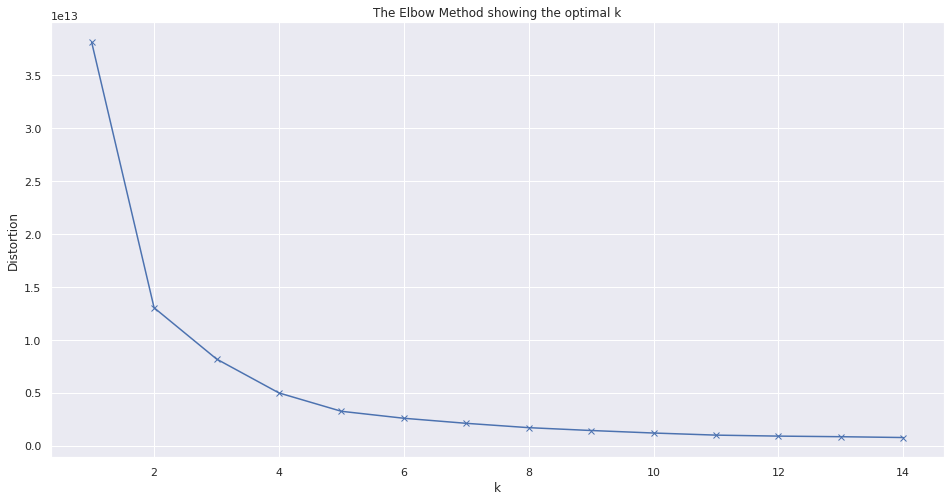

In [182]:
from sklearn.cluster import KMeans

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_fl_alldata_cluster_clean)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

##### As shown in the graph the optimum number of cluster is 4

Now lets run the K-Means cluster with 4 clusters

In [183]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_fl_alldata_cluster_clean)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 0, 3, 2, 4, 3, 0, 3, 0], dtype=int32)

In [184]:
df_fl_alldata_klabel = df_fl_alldata_cluster_clean

# add clustering labels
df_fl_alldata_klabel.insert(0, 'Cluster Labels', kmeans.labels_)
df_fl_alldata_klabel.insert(0, 'County Name', df_fl_alldata.index)

df_fl_alldata_klabel.head()

County Name  Cluster Labels  Population  Total Index Crimes  \
0   Alachua County               0    267306.0              9010.0   
1     Baker County               3     28249.0               396.0   
2       Bay County               0    167283.0              6533.0   
3  Bradford County               3     28682.0               555.0   
4   Brevard County               2    594469.0             14493.0   

   Crime Rate per 100,000 Population  Murder  Rape^  Robbery  \
0                            11837.8     6.0  282.0    293.0   
1                             1401.8     0.0   14.0      7.0   
2                            31508.0     8.0   91.0    103.0   
3                             7239.6     1.0   12.0      6.0   
4                            31931.8    23.0  262.0    332.0   

   Aggravated Assault^^  Burglary  Larceny  Motor Vehicle Theft  \
0                1184.0    1008.0   5643.0                594.0   
1                 100.0      63.0    181.0                 31.0   
2                 624.0    1097.0   4139.0                471.0   
3                  93.0      98.0    311.0                 34.0   
4                1607.0    2019.0   9322.0                928.0   

   Annual Change (%)     HPI  Single Family  Mobile Home  Condominium  \
0               5.12  432.11         177826      59405.0      95480.0   
1               4.73  193.17         139243      63416.0          0.0   
2               8.66  644.54         153453      48217.0     211142.0   
3               3.45  202.29         103149      49872.0       -100.0   
4               5.08  541.83         211056      66250.0     168862.0   

   Multifamily Less than 10 Units  TOT_MALE  TOT_FEMALE  WA_MALE  WA_FEMALE  \
0                        157064.0    129680      139363    91487      96471   
1                        105765.0     15365       13845    12261      11899   
2                        133793.0     86622       88083    71512      72165   
3                        105217.0     15692       12509    11386      10066   
4                        234854.0    294384      307558   246186     254403   

   BA_MALE  BA_FEMALE  AA_MALE  AA_FEMALE  NH_MALE  NH_FEMALE  H_MALE  \
0    25573      29932     8054       8497   116056     124765   13624   
1     2666       1490       87        108    14909      13470     456   
2     9815       9846     1685       2385    80629      82438    5993   
3     3852       1949       78         99    14793      12077     899   
4    31254      33815     6847       8819   262056     274274   32328   

   H_FEMALE  accounting  airport  amusement_park  aquarium  art_gallery  atm  \
0     14598          19       18               6         1           21   22   
1       375          17       17               0         0            2   16   
2      5645          16       13              10         1           20   21   
3       432          16       18               6         2           20   20   
4     33284          13       20               9         3           20   11   

   bakery  bank  bar  beauty_salon  bicycle_store  book_store  bowling_alley  \
0      23    11   32            28             12          19              3   
1      15    14   24            26              2           2              1   
2      17    12   38            25              9          14              3   
3      22    10   30            33             14          19              5   
4      20     9   41            26             20          19              6   

   bus_station  cafe  campground  car_dealer  car_rental  car_repair  \
0           20    17          20          23          10          34   
1            0    11          20          20           3          22   
2            9    11          20          22          16          28   
3           19    16          20          22          10          33   
4           20    15          20          21          15          28   

   car_wash  casino  cemetery  church  city_hall  

In [186]:
df_fl_alldata_final = df_fl_allcrime_clean.set_index('County Name').join(df_fl_hpi_2019_clean.set_index('County'), how="outer") \
    .join(df_fl_housedata_all.set_index('Geography'), how="outer") \
    .join(df_fl_hprice_sf.set_index('County Name'), how="outer") \
    .join(df_fl_race, how="outer") \
    .join(df_fl_top_ven.set_index('County Name'), how="outer") \
    .join(df_fl_ven_onehot, how="outer") \
    .join(df_fl_alldata_klabel[['County Name', 'Cluster Labels']].set_index('County Name'), how="outer")
    
df_fl_alldata_final

Population  Total Index Crimes  \
Alachua County       267306.0              9010.0   
Baker County          28249.0               396.0   
Bay County           167283.0              6533.0   
Bradford County       28682.0               555.0   
Brevard County       594469.0             14493.0   
...                       ...                 ...   
Union County          15505.0               130.0   
Volusia County       538703.0             12729.0   
Wakulla County        32976.0               579.0   
Walton County         70071.0              1086.0   
Washington County     25387.0               308.0   

                   Crime Rate per 100,000 Population  Murder  Rape^  Robbery  \
Alachua County                               11837.8     6.0  282.0    293.0   
Baker County                                  1401.8     0.0   14.0      7.0   
Bay County                                   31508.0     8.0   91.0    103.0   
Bradford County                               7239.6     1.0   12.0      6.0   
Brevard County                               31931.8    23.0  262.0    332.0   
...                                              ...     ...    ...      ...   
Union County                                   838.4     0.0   12.0      3.0   
Volusia County                               34529.4    25.0   98.0    278.0   
Wakulla County                                1752.8     0.0   11.0      2.0   
Walton County                                 5203.5     1.0   18.0      4.0   
Washington County                             4703.4     0.0    2.0      6.0   

                   Aggravated Assault^^  Burglary  Larceny  \
Alachua County                   1184.0    1008.0   5643.0   
Baker County                      100.0      63.0    181.0   
Bay County                        624.0    1097.0   4139.0   
Bradford County                    93.0      98.0    311.0   
Brevard County                   1607.0    2019.0   9322.0   
...                                 ...       ...      ...   
Union County                       32.0      30.0     47.0   
Volusia County                   1511.0    1698.0   8282.0   
Wakulla County                     63.0     124.0    346.0   
Walton County                     120.0     153.0    713.0   
Washington County                  53.0      57.0    162.0   

                   Motor Vehicle Theft  Annual Change (%)     HPI  \
Alachua County                   594.0               5.12  432.11   
Baker County                      31.0               4.73  193.17   
Bay County                       471.0               8.66  644.54   
Bradford County                   34.0               3.45  202.29   
Brevard County                   928.0               5.08  541.83   
...                                ...                ...     ...   
Union County                       6.0               2.52   79.61   
Volusia County                   837.0               6.44  565.97   
Wakulla County                    33.0               5.54  187.58   
Walton County                     77.0               7.75  317.21   
Washington County                 28.0              18.03  191.59   

                   Single Family  Mobile Home  Condominium  \
Alachua County            177826      59405.0      95480.0   
Baker County              139243      63416.0          0.0   
Bay County                153453      48217.0     211142.0   
Bradford County           103149      49872.0       -100.0   
Brevard County            211056      66250.0     168862.0   
...                          ...          ...          ...   
Union County               86789      45335.0       -100.0   
Volusia County            193924      79132.0     216974.0   
Wakulla County            148571      53405.0     113245.0   
Walton County             493477      35640.0     384452.0   
Washington County          82623      40194.0          0.0   

                   Multifamily Less than 10 Units  Mean assessed value  \
Alachua County              

In [187]:
pd.options.display.max_columns = None

## Analyzing Cluster

So now we have 4 different clusters and we can analyze these clusters to find the similarities and based on that we can name clusters.

In [188]:
df_fl_alldata_final[df_fl_alldata_final['Cluster Labels'] == 0]

Population  Total Index Crimes  \
Alachua County         267306.0              9010.0   
Bay County             167283.0              6533.0   
Charlotte County       181770.0              2481.0   
Clay County            215246.0              3809.0   
Collier County         376706.0              5204.0   
Escambia County        321134.0             10979.0   
Flagler County         110695.0              1379.0   
Hernando County        188358.0              3108.0   
Indian River County    154939.0              2447.0   
Lake County            357247.0              7478.0   
Leon County            296499.0             11402.0   
Manatee County         392004.0              8422.0   
Marion County          360421.0              8397.0   
Martin County          158598.0              2300.0   
Monroe County           76212.0              1704.0   
Nassau County           85070.0              1270.0   
Okaloosa County        200675.0              4495.0   
Osceola County         370552.0              8198.0   
Santa Rosa County      179054.0              1885.0   
Sarasota County        421685.0              8267.0   
Seminole County        471735.0              9472.0   
St. Johns County       254412.0              3022.0   
St. Lucie County       309359.0              5045.0   
Walton County           70071.0              1086.0   

                     Crime Rate per 100,000 Population  Murder  Rape^  \
Alachua County                                 11837.8     6.0  282.0   
Bay County                                     31508.0     8.0   91.0   
Charlotte County                                2801.7     2.0   41.0   
Clay County                                     6322.6     4.0   98.0   
Collier County                                  3518.1     9.0  127.0   
Escambia County                                 7235.5    27.0  186.0   
Flagler County                                  6302.8     3.0   38.0   
Hernando County                                 5925.9     6.0   66.0   
Indian River County                             6406.0     6.0   36.0   
Lake County                                    30686.2     9.0  122.0   
Leon County                                     6416.1    21.0  237.0   
Manatee County                                 12208.5    17.0  209.0   
Marion County                                  16503.5    31.0  227.0   
Martin County                                   5579.6     5.0   96.0   
Monroe County                                   5942.8     2.0   36.0   
Nassau County                                   2885.3     2.0   39.0   
Okaloosa County                                10140.0    12.0  113.0   
Osceola County                                  6673.2    14.0  138.0   
Santa Rosa County                               5956.4     5.0   61.0   
Sarasota County                                 8317.7     9.0   77.0   
Seminole County                                18169.3     6.0  201.0   
St. Johns County                                6075.3     6.0   44.0   
St. Lucie County                                6626.8    19.0  104.0   
Walton County                                   5203.5     1.0   18.0   

                     Robbery  Aggravated Assault^^  Burglary  Larceny  \
Alachua County         293.0                1184.0    1008.0   5643.0   
Bay County             103.0                 624.0    1097.0   4139.0   
Charlotte County        20.0                 304.0     273.0   1708.0   
Clay County             68.0                 384.0     544.0   2522.0   
Collier County         147.0                 613.0     469.0   3530.0   
Escambia County        337.0                1227.0    1828.0   6724.0   
Flagler County          11.0                 156.0     181.0    898.0   
Hernando County         53.0                 393.0     457.0   1945.0   
Indian River County     31.0                 279.0     248.0   1708.0   
Lake County            129.0                 747.0    1306.0   4562.0   
Leon County     

In [189]:
df_fl_alldata_final[df_fl_alldata_final['Cluster Labels'] == 1]

Population  Total Index Crimes  \
Miami-Dade County   2812130.0             98880.0   

                   Crime Rate per 100,000 Population  Murder  Rape^  Robbery  \
Miami-Dade County                           128036.9   202.0  955.0   3649.0   

                   Aggravated Assault^^  Burglary  Larceny  \
Miami-Dade County                8531.0    7936.0  69952.0   

                   Motor Vehicle Theft  Annual Change (%)    HPI  \
Miami-Dade County               7655.0               5.48  868.4   

                   Single Family  Mobile Home  Condominium  \
Miami-Dade County         387887      61325.0     301923.0   

                   Multifamily Less than 10 Units  Mean assessed value  \
Miami-Dade County                        353517.0               285359   

                   Mean just value  2019 Mean Sales Price  \
Miami-Dade County           387887                 521041   

                   2019 25th Percentile Sales Price  \
Miami-Dade County                            280000   

                   2019 75th Percentile Sales Price  TOT_MALE  TOT_FEMALE  \
Miami-Dade County                            471000   1320180     1396760   

                   WA_MALE  WA_FEMALE  BA_MALE  BA_FEMALE  AA_MALE  AA_FEMALE  \
Miami-Dade County  1046219    1101492   231895     249865    20809      23302   

                   NH_MALE  NH_FEMALE  H_MALE  H_FEMALE 1st Most Common Venue  \
Miami-Dade County   409833     420743  910347    976017     point_of_interest   

                  2nd Most Common Venue 3rd Most Common Venue  \
Miami-Dade County         establishment                 store   

                  4th Most Common Venue 5th Most Common Venue  \
Miami-Dade County                health                  food   

                  6th Most Common Venue 7th Most Common Venue  \
Miami-Dade County            restaurant               lodging   

                  8th Most Common Venue 9th Most Common Venue  \
Miami-Dade County       transit_station      place_of_worship   

                  10th Most Common Venue 11th Most Common Venue  \
Miami-Dade County     tourist_attraction                finance   

                    12th Most Common Venue 13th Most Common Venue  \
Miami-Dade County  local_government_office                 school   

                  14th Most Common Venue 15th Most Common Venue  \
Miami-Dade County                    bar                   park   

                  16th Most Common Venue 17th Most Common Venue  \
Miami-Dade County         clothing_store       home_goods_store   

                  18th Most Common Venue 19th Most Common Venue  \
Miami-Dade County                 doctor          meal_takeaway   

                  20th Most Common Venue accounting airport amusement_park  \
Miami-Dade County             car_repair         20      20             20   

                  aquarium art_gallery atm bakery bank bar beauty_salon  \
Miami-Dade County       20          20  20     22    9  48           21   

                  bicycle_store book_store bowling_alley bus_station cafe  \
Miami-Dade County            17         16            10          20   23   

                  campground car_dealer car_rental car_repair car_wash casino  \
Miami-Dade County         20         20         14         28       12     15   

                  cemetery church city_hall clothing_store convenience_store  \
Miami-Dade County       20     23        20             39                 9   

                  courthouse dentist department_store doctor drugstore  \
Miami-Dade County         19      20               14     33         1   

                  electrician electronics_store establishment finance  \
Miami-Dade County          20                19          1347      59   

                  fire_station florist food funeral_home furniture_store  \
Miami-Dade County           20      20  130           19              14   

                  gas_station general_contractor grocery_or_s

In [190]:
df_fl_alldata_final[df_fl_alldata_final['Cluster Labels'] == 2]

Population  Total Index Crimes  \
Brevard County     594469.0             14493.0   
Duval County       970672.0             37710.0   
Lee County         735148.0             10869.0   
Pasco County       524260.0              9567.0   
Pinellas County    978045.0             26305.0   
Polk County        690606.0             13787.0   
Volusia County     538703.0             12729.0   

                 Crime Rate per 100,000 Population  Murder  Rape^  Robbery  \
Brevard County                             31931.8    23.0  262.0    332.0   
Duval County                               11441.6   131.0  584.0   1331.0   
Lee County                                  6068.1    23.0  246.0    386.0   
Pasco County                               13928.9    14.0  251.0    293.0   
Pinellas County                            51576.1    40.0  460.0    620.0   
Polk County                                26475.5    23.0  166.0    300.0   
Volusia County                             34529.4    25.0   98.0    278.0   

                 Aggravated Assault^^  Burglary  Larceny  Motor Vehicle Theft  \
Brevard County                 1607.0    2019.0   9322.0                928.0   
Duval County                   4041.0    5096.0  23581.0               2946.0   
Lee County                     1324.0    1343.0   6792.0                755.0   
Pasco County                   1135.0    1171.0   6155.0                548.0   
Pinellas County                2259.0    2517.0  18785.0               1624.0   
Polk County                    1501.0    1947.0   8914.0                936.0   
Volusia County                 1511.0    1698.0   8282.0                837.0   

                 Annual Change (%)     HPI  Single Family  Mobile Home  \
Brevard County                5.08  541.83         211056      66250.0   
Duval County                  4.99  541.43         185205      58085.0   
Lee County                    4.03  503.49         274080      83317.0   
Pasco County                  8.12  362.85         179011      51574.0   
Pinellas County               6.76  722.17         254224      56461.0   
Polk County                   7.50  536.26         159732      60280.0   
Volusia County                6.44  565.97         193924      79132.0   

                 Condominium  Multifamily Less than 10 Units  \
Brevard County      168862.0                        234854.0   
Duval County        141472.0                        217312.0   
Lee County          215250.0                        255791.0   
Pasco County         71786.0                        131792.0   
Pinellas County     189386.0                        273544.0   
Polk County          69962.0                         98577.0   
Volusia County      216974.0                        186899.0   

                 Mean assessed value  Mean just value  2019 Mean Sales Price  \
Brevard County                160411           211056                 266566   
Duval County                  154830           185205                 230185   
Lee County                    235629           274080                 334328   
Pasco County                  149511           179011                 214439   
Pinellas County               192591           254224                 337091   
Polk County                   130827           159732                 204703   
Volusia County                150299           193924                 243897   

                 2019 25th Percentile Sales Price  \
Brevard County                             169800   
Duval County                               142100   
Lee County                                 189835   
Pasco County                               134000   
Pinellas County                            190000   
Polk County                                150000   
Volusia County                             164900   

                 2019 75th Percentile Sales Price  TOT_MALE  TOT_FEMALE  \
Brevard County                             315000    294384      307558   
Duval County

In [191]:
df_fl_alldata_final[df_fl_alldata_final['Cluster Labels'] == 3]

Population  Total Index Crimes  \
Baker County          28249.0               396.0   
Bradford County       28682.0               555.0   
Calhoun County        14067.0               150.0   
Citrus County        147744.0              2428.0   
Columbia County       70492.0              2032.0   
DeSoto County         36065.0               777.0   
Dixie County          16610.0               238.0   
Franklin County        7051.0               270.0   
Gadsden County        42828.0               942.0   
Gilchrist County      17766.0               199.0   
Glades County         13121.0               149.0   
Gulf County           13082.0               232.0   
Hamilton County       14600.0               312.0   
Hardee County         27385.0               560.0   
Hendry County         40120.0               993.0   
Highlands County     103434.0              2621.0   
Holmes County         20049.0               241.0   
Jackson County        10070.0               368.0   
Jefferson County      14776.0               296.0   
Lafayette County       8482.0                50.0   
Levy County           41330.0              1164.0   
Liberty County         8772.0                85.0   
Madison County        16572.0               285.0   
Okeechobee County     41808.0              1175.0   
Putnam County         71918.0              1535.0   
Sumter County        128633.0              1388.0   
Suwannee County       45423.0               804.0   
Taylor County         22458.0               683.0   
Union County          15505.0               130.0   
Wakulla County        32976.0               579.0   
Washington County     25387.0               308.0   

                   Crime Rate per 100,000 Population  Murder  Rape^  Robbery  \
Baker County                                  1401.8     0.0   14.0      7.0   
Bradford County                               7239.6     1.0   12.0      6.0   
Calhoun County                                2709.7     1.0    0.0      1.0   
Citrus County                                 1632.6     4.0   29.0     40.0   
Columbia County                               9483.5     3.0   21.0     47.0   
DeSoto County                                 4249.2     3.0   19.0     13.0   
Dixie County                                  1792.3     1.0   14.0      2.0   
Franklin County                               3829.2     0.0    1.0      0.0   
Gadsden County                               13919.3     3.0   22.0     21.0   
Gilchrist County                              2021.1     0.0    8.0      2.0   
Glades County                                 1128.0     0.0    2.0      0.0   
Gulf County                                   3281.3     1.0    1.0      1.0   
Hamilton County                               8261.5     1.0    4.0      4.0   
Hardee County                                 7064.8     1.0    6.0      7.0   
Hendry County                                 5324.5     8.0   20.0     16.0   
Highlands County                             11545.5    11.0   30.0     58.0   
Holmes County                                 1620.3     1.0   12.0      3.0   
Jackson County                                8849.1     0.0    6.0      7.0   
Jefferson County                              4528.4     1.0    2.0      3.0   
Lafayette County                               589.5     0.0    1.0      0.0   
Levy County                                  10562.2     1.0   19.0      2.0   
Liberty County                                 969.0     1.0    0.0      1.0   
Madison County                                1707.7     0.0   14.0      3.0   
Okeechobee County                             6332.0     2.0   21.0     28.0   
Putnam County                                10986.0     4.0   22.0     24.0   
Sumter County                                 3798.7     5.0   18.0     20.0   
Suwannee County                               4754.1     2.0   17.0     10.0   
Taylor County                                 7036.3     0.0   11.0      7.0   
Un

In [192]:
df_fl_alldata_final[df_fl_alldata_final['Cluster Labels'] == 4]

Population  Total Index Crimes  \
Broward County        1919644.0             57348.0   
Hillsborough County   1444870.0             23601.0   
Orange County         1386080.0             48850.0   
Palm Beach County     1447857.0             37571.0   

                     Crime Rate per 100,000 Population  Murder  Rape^  \
Broward County                                 86460.3   111.0  688.0   
Hillsborough County                             8925.1    66.0  392.0   
Orange County                                  37538.0    91.0  718.0   
Palm Beach County                             101074.1    87.0  561.0   

                     Robbery  Aggravated Assault^^  Burglary  Larceny  \
Broward County        2134.0                4398.0    5480.0  39393.0   
Hillsborough County    609.0                2589.0    2689.0  15575.0   
Orange County         1789.0                5180.0    5757.0  31425.0   
Palm Beach County     1324.0                3671.0    3493.0  25734.0   

                     Motor Vehicle Theft  Annual Change (%)     HPI  \
Broward County                    5144.0               4.87  556.94   
Hillsborough County               1681.0               6.80  680.66   
Orange County                     3890.0               5.76  726.58   
Palm Beach County                 2701.0               4.17  561.05   

                     Single Family  Mobile Home  Condominium  \
Broward County              360487      88718.0     178017.0   
Hillsborough County         225908      77962.0     133388.0   
Orange County               267390      67122.0     128745.0   
Palm Beach County           405332      69205.0     206417.0   

                     Multifamily Less than 10 Units  Mean assessed value  \
Broward County                             336694.0               270458   
Hillsborough County                        187568.0               180457   
Orange County                              218510.0               219206   
Palm Beach County                          282852.0               328183   

                     Mean just value  2019 Mean Sales Price  \
Broward County                360487                 414954   
Hillsborough County           225908                 289674   
Orange County                 267390                 333657   
Palm Beach County             405332                 606679   

                     2019 25th Percentile Sales Price  \
Broward County                                 259000   
Hillsborough County                            181000   
Orange County                                  217000   
Palm Beach County                              262000   

                     2019 75th Percentile Sales Price  TOT_MALE  TOT_FEMALE  \
Broward County                                 450000    950870     1001908   
Hillsborough County                            325000    720329      751639   
Orange County                                  369900    683793      709659   
Palm Beach County                              550000    725445      771325   

                     WA_MALE  WA_FEMALE  BA_MALE  BA_FEMALE  AA_MALE  \
Broward County        611505     620078   276743     313334    35610   
Hillsborough County   539014     551571   124668     139627    31261   
Orange County         470313     477547   152256     164950    36765   
Palm Beach County     543499     573822   141632     155159    20669   

                     AA_FEMALE  NH_MALE  NH_FEMALE  H_MALE  H_FEMALE  \
Broward County           40007   655882     689914  294988    311994   
Hillsborough County      34217   502967     532105  217362    219534   
Orange County            42370   459931     478226  223862    231433   
Palm Beach County        23405   550686     596500  174759    174825   

                    1st Most Common Venue 2nd Most Common Venue  \
Broward County          point_of_interest         establishment   
Hillsborough County     point_of_interest         establishment   
Orange County               establ

In [193]:
fl_data_norm = df_fl_alldata_final
fl_data_norm_2 = fl_data_norm[['Population', 'Total Index Crimes', 'HPI', 'Single Family']]

fl_data_norm_2['White American'] = fl_data_norm['WA_MALE'] + fl_data_norm['WA_FEMALE']
fl_data_norm_2['Black American'] = fl_data_norm['BA_MALE'] + fl_data_norm['BA_FEMALE']
fl_data_norm_2['Asian American'] = fl_data_norm['AA_MALE'] + fl_data_norm['AA_FEMALE']
fl_data_norm_2['Not Hispanic'] = fl_data_norm['NH_MALE'] + fl_data_norm['NH_FEMALE']
fl_data_norm_2['Hispanic'] = fl_data_norm['H_MALE'] + fl_data_norm['H_FEMALE']

#fl_data_norm_2
fl_data_norm_3 = (fl_data_norm_2-fl_data_norm_2.min())/(fl_data_norm_2.max()-fl_data_norm_2.min())

fl_data_norm_3['Cluster Labels'] = fl_data_norm['Cluster Labels']
fl_data_norm_3

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Population  Total Index Crimes       HPI  Single Family  \
Alachua County       0.092780            0.090661  0.446112       0.171369   
Baker County         0.007557            0.003501  0.143718       0.112320   
Bay County           0.057122            0.065597  0.714956       0.134067   
Bradford County      0.007711            0.005110  0.155260       0.057081   
Brevard County       0.209412            0.146140  0.584970       0.222225   
...                       ...                 ...       ...            ...   
Union County         0.003014            0.000809  0.000000       0.032043   
Volusia County       0.189532            0.128291  0.615521       0.196006   
Wakulla County       0.009242            0.005353  0.136643       0.126596   
Walton County        0.022466            0.010483  0.300699       0.654451   
Washington County    0.006537            0.002611  0.141718       0.025667   

                   White American  Black American  Asian American  \
Alachua County           0.084782        0.092444        0.208909   
Baker County             0.008288        0.005268        0.002162   
Bay County               0.064103        0.031591        0.051143   
Bradford County          0.007023        0.008061        0.001934   
Brevard County           0.230783        0.108681        0.197722   
...                           ...             ...             ...   
Union County             0.002303        0.004058        0.000822   
Volusia County           0.213365        0.106412        0.138464   
Wakulla County           0.009986        0.006176        0.002591   
Walton County            0.027995        0.004830        0.012767   
Washington County        0.006542        0.004754        0.001694   

                   Not Hispanic  Hispanic  Cluster Labels  
Alachua County         0.174493  0.014745               0  
Baker County           0.015781  0.000221               3  
Bay County             0.116404  0.005951               0  
Bradford County        0.014654  0.000486               3  
Brevard County         0.395262  0.034570               2  
...                         ...       ...             ...  
Union County           0.005327  0.000232               3  
Volusia County         0.345959  0.043763               2  
Wakulla County         0.018797  0.000483               3  
Walton County          0.046336  0.002322               0  
Washington County      0.012881  0.000298               3  

[67 rows x 10 columns]

## Labeling teh clusters

Lets analyze the clusters for each attributes to find out simailarites and how they are grouped. I will be using boxplot for each cluster for diffrent attributes to find out simalrities.

In [136]:
def get_norm_df(df, cols):
    df2 = pd.DataFrame(columns=['Cluster Labels', 'measure', 'tag'])
    for col in cols:
        col_list = ['Cluster Labels', col]
        #print(col_list_final)
        df1 = df[col_list]
        df1['tag'] = col
        df1.columns = ['Cluster Labels', 'measure', 'tag']
        df2 = pd.concat([df2, df1])
    return df2

In [194]:
cols = ['Population', 'Total Index Crimes', 'HPI', 'Single Family']
fl_data_norm_cluster = get_norm_df(fl_data_norm_3, cols)
fl_data_norm_cluster

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster Labels   measure            tag
Alachua County                 0  0.092780     Population
Baker County                   3  0.007557     Population
Bay County                     0  0.057122     Population
Bradford County                3  0.007711     Population
Brevard County                 2  0.209412     Population
...                          ...       ...            ...
Union County                   3  0.032043  Single Family
Volusia County                 2  0.196006  Single Family
Wakulla County                 3  0.126596  Single Family
Walton County                  0  0.654451  Single Family
Washington County              3  0.025667  Single Family

[268 rows x 3 columns]

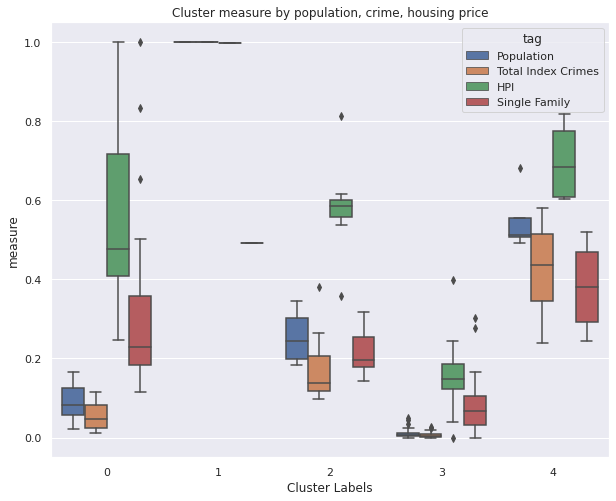

In [195]:
sns.set(rc={'figure.figsize':(10,8)})
ax1 = sns.boxplot(x="Cluster Labels", y="measure", hue='tag', data=fl_data_norm_cluster)

ax1.set_title('Cluster measure by population, crime, housing price')
None

In [196]:
cols = ['White American', 'Black American', 'Asian American', 'Not Hispanic', 'Hispanic']
fl_data_norm_cluster_race = get_norm_df(fl_data_norm_3, cols)
fl_data_norm_cluster_race

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster Labels   measure             tag
Alachua County                 0  0.084782  White American
Baker County                   3  0.008288  White American
Bay County                     0  0.064103  White American
Bradford County                3  0.007023  White American
Brevard County                 2  0.230783  White American
...                          ...       ...             ...
Union County                   3  0.000232        Hispanic
Volusia County                 2  0.043763        Hispanic
Wakulla County                 3  0.000483        Hispanic
Walton County                  0  0.002322        Hispanic
Washington County              3  0.000298        Hispanic

[335 rows x 3 columns]

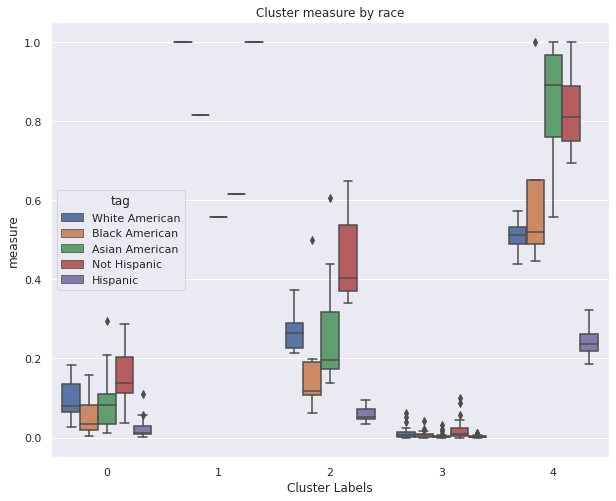

In [197]:
sns.set(rc={'figure.figsize':(10,8)})
ax2 = sns.boxplot(x="Cluster Labels", y="measure", hue='tag', data=fl_data_norm_cluster_race)
ax2.set_title('Cluster measure by race')
None

In [198]:
df_fl_ven_cluster_anly = df_fl_ven_onehot.fillna(value=0)
df_fl_ven_cluster_anly

accounting  airport  amusement_park  aquarium  art_gallery  \
County Name                                                                     
Alachua County             19       18               6         1           21   
Baker County               17       17               0         0            2   
Bay County                 16       13              10         1           20   
Bradford County            16       18               6         2           20   
Brevard County             13       20               9         3           20   
...                       ...      ...             ...       ...          ...   
Union County               16       20               5         1           20   
Volusia County             17       20              15         7           20   
Wakulla County             19       16               2         1           20   
Walton County              17       20               7         1           21   
Washington County          18       19              10         1           20   

                   atm  bakery  bank  bar  beauty_salon  bicycle_store  \
County Name                                                              
Alachua County      22      23    11   32            28             12   
Baker County        16      15    14   24            26              2   
Bay County          21      17    12   38            25              9   
Bradford County     20      22    10   30            33             14   
Brevard County      11      20     9   41            26             20   
...                ...     ...   ...  ...           ...            ...   
Union County        19      22    11   31            29             12   
Volusia County      20      24    10   41            26             16   
Wakulla County      16      20    10   36            29              9   
Walton County       19      17    12   33            24             15   
Washington County   16      12    11   31            25              5   

                   book_store  bowling_alley  bus_station  cafe  campground  \
County Name                                                                   
Alachua County             19              3           20    17          20   
Baker County                2              1            0    11          20   
Bay County                 14              3            9    11          20   
Bradford County            19              5           19    16          20   
Brevard County             19              6           20    15          20   
...                       ...            ...          ...   ...         ...   
Union County               19              4           19    15          20   
Volusia County             20             13           20    19          20   
Wakulla County             19              3           20    21          19   
Walton County              17              2           10    18          20   
Washington County          16              3            8    10          20   

                   car_dealer  car_rental  car_repair  car_wash  casino  \
County Name                                                               
Alachua County             23          10          34        18       1   
Baker County               20           3          22        19       2   
Bay County                 22          16          28        17       1   
Bradford County            22          10          33        16       2   
Brevard County             21          15          28        18       5   
...                       ...         ...         ...       ...     ...   
Union County               22          11          29        18       3   
Volusia County             23          15          34        17       4   
Wakulla County             20          14          27        16       0   
Walton County              20          13          28        18       1   
Washington County          21          16          30        18       1   

In [199]:
cols_ven = ['store', 'airport', 'health', 'food', 'lodging', 'restaurant', 'school', 'park', 'finance', 'bar', 'doctor', 'tourist_attraction', 'place_of_worship','art_gallery', 'amusement_park', 'aquarium', 'casino', 'night_club', 'museum', 'spa', 'university', 'zoo']
#cols_ven = ['art_gallery', 'amusement_park', 'aquarium']
fl_data_norm_cluster_ven = get_norm_df(df_fl_alldata_klabel.reset_index(drop = True), cols_ven)
fl_data_norm_cluster_ven

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cluster Labels measure    tag
0               0     329  store
1               3     262  store
2               0     289  store
3               3     300  store
4               2     282  store
..            ...     ...    ...
62              3       7    zoo
63              2       7    zoo
64              3       1    zoo
65              0       1    zoo
66              3       4    zoo

[1474 rows x 3 columns]

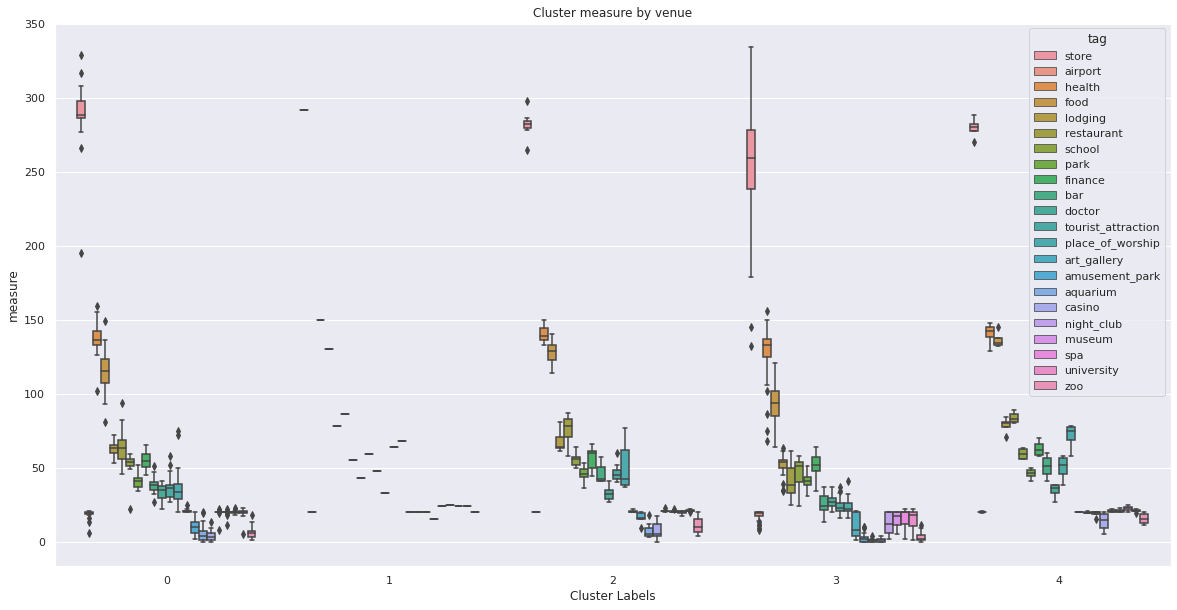

In [200]:
sns.set(rc={'figure.figsize':(20,10)})
ax3 = sns.boxplot(x="Cluster Labels", y="measure", hue='tag', data=fl_data_norm_cluster_ven)
ax3.set_title('Cluster measure by venue')
None

### Labeling the Clusters - final conclusion

#### Cluster 0 
* Average Population
* Below Average Crime rate
* HPI below average
* Average White American Population
* Below Average Black American population
* Below Average Asian American Population
* Above Average Not Hispanic American Population
* Below Average Hispanic American Population
* More Tourist attraction

#### Cluster 1 
* Very High in Population
* Highest in Crime
* High HPI and High House Price
* High in White American Population
* Average Black American population
* Below Average Asian American Population
* Below Average Not Hispanic American Population
* Below Average Hispanic American Population
* More number of Universities, Night club, Museum and more amusement park

#### Cluster 2 
* Above Average Population
* Average in Crime
* HPI is low
* High in White American Population
* Below Average Black American population
* Below Average Asian American Population
* High Not Hispanic American Population
* Below Average Hispanic American Population

#### Cluster 3 
* Low in Population
* Low in Crime
* Average HPI but low House Price
* Below Average in White American Population
* Low Average Black American population
* Low Asian American Population
* Below Average Not Hispanic American Population
* Low Hispanic American Population
* Few Tourist attraction, low in cafe, bar, restaurant, store, casion, amusement park and place of worship

#### Cluster 4 
* High in Population
* Above average in Crime
* lowest HPI
* Above Average in White American Population
* Above Average Black American population
* Above Average Asian American Population
* Above Average Not Hispanic American Population
* Average Hispanic American Population
* More number of lodging, amusement park and place of worship compare to other clusters

In [219]:
cluster_label = [[0, 'Average Population, Below Average Crime rate, HPI below average, Average White American Population, Below Average Black American population, Below Average Asian American Population, Above Average Not Hispanic American Population, Below Average Hispanic American Population, More Tourist attraction', 'red'],
                       [1, 'Very High in Population, Highest in Crime, High HPI and High House Price, High in White American Population, Average Black American population, Below Average Asian American Population, Below Average Not Hispanic American Population, Below Average Hispanic American Population, More number of Universities, Night club, Museum and more amusement park', 'yellow'],
                       [2, 'Above Average Population, Average in Crime, HPI is low, High in White American Population, Below Average Black American population, Below Average Asian American Population, High Not Hispanic American Population, Below Average Hispanic American Population', 'green'],
                       [3, 'Low in Population, Low in Crime, Average HPI but low House Price, Below Average in White American Population, Low Average Black American population, Low Asian American Population, Below Average Not Hispanic American Population, Low Hispanic American Population, Few Tourist attraction, low in cafe, bar, restaurant, store, casion, amusement park and place of worship', 'black'],
                       [4, 'High in Population, Above average in Crime, lowest HPI, Above Average in White American Population, Above Average Black American population, Above Average Asian American Population, Above Average Not Hispanic American Population, Average Hispanic American Population, More number of lodging, amusement park and place of worship compare to other clusters', 'blue']]
df_cluster_label = pd.DataFrame(cluster_label, columns=['Cluster Labels', 'Cluster description', 'color'])
#df_cluster_label.columns = ['CLuster Labels', 'CLuster description']
df_cluster_label

Cluster Labels                                Cluster description   color
0               0  Average Population, Below Average Crime rate, ...     red
1               1  Very High in Population, Highest in Crime, Hig...  yellow
2               2  Above Average Population, Average in Crime, HP...   green
3               3  Low in Population, Low in Crime, Average HPI b...   black
4               4  High in Population, Above average in Crime, lo...    blue

In [204]:
df_fl_alldata_final.reset_index(inplace = True)
df_fl_alldata_final.rename(columns={'index':'County Name'}, inplace=True)
df_fl_alldata_final

level_0        County Name  Population  Total Index Crimes  \
0         0     Alachua County    267306.0              9010.0   
1         1       Baker County     28249.0               396.0   
2         2         Bay County    167283.0              6533.0   
3         3    Bradford County     28682.0               555.0   
4         4     Brevard County    594469.0             14493.0   
..      ...                ...         ...                 ...   
62       62       Union County     15505.0               130.0   
63       63     Volusia County    538703.0             12729.0   
64       64     Wakulla County     32976.0               579.0   
65       65      Walton County     70071.0              1086.0   
66       66  Washington County     25387.0               308.0   

    Crime Rate per 100,000 Population  Murder  Rape^  Robbery  \
0                             11837.8     6.0  282.0    293.0   
1                              1401.8     0.0   14.0      7.0   
2                             31508.0     8.0   91.0    103.0   
3                              7239.6     1.0   12.0      6.0   
4                             31931.8    23.0  262.0    332.0   
..                                ...     ...    ...      ...   
62                              838.4     0.0   12.0      3.0   
63                            34529.4    25.0   98.0    278.0   
64                             1752.8     0.0   11.0      2.0   
65                             5203.5     1.0   18.0      4.0   
66                             4703.4     0.0    2.0      6.0   

    Aggravated Assault^^  Burglary  Larceny  Motor Vehicle Theft  \
0                 1184.0    1008.0   5643.0                594.0   
1                  100.0      63.0    181.0                 31.0   
2                  624.0    1097.0   4139.0                471.0   
3                   93.0      98.0    311.0                 34.0   
4                 1607.0    2019.0   9322.0                928.0   
..                   ...       ...      ...                  ...   
62                  32.0      30.0     47.0                  6.0   
63                1511.0    1698.0   8282.0                837.0   
64                  63.0     124.0    346.0                 33.0   
65                 120.0     153.0    713.0                 77.0   
66                  53.0      57.0    162.0                 28.0   

    Annual Change (%)     HPI  Single Family  Mobile Home  Condominium  \
0                5.12  432.11         177826      59405.0      95480.0   
1                4.73  193.17         139243      63416.0          0.0   
2                8.66  644.54         153453      48217.0     211142.0   
3                3.45  202.29         103149      49872.0       -100.0   
4                5.08  541.83         211056      66250.0     168862.0   
..                ...     ...            ...          ...          ...   
62               2.52   79.61          86789      45335.0       -100.0   
63               6.44  565.97         193924      79132.0     216974.0   
64               5.54  187.58         148571      53405.0     113245.0   
65               7.75  317.21         493477      35640.0     384452.0   
66              18.03  191.59          82623      40194.0          0.0   

    Multifamily Less than 10 Units  Mean assessed value  Mean just value  \
0                         157064.0               155034           177826   
1                         105765.0               121630           139243   
2                         133793.0               147369           153453   
3                         105217.0                97165           103149   
4                         234854.0               160411           211056   
..                             ...                  ...              ...   
62                          -100.0                82273            86789   
63                        186899.0               150299           193924   
64                          -100.0      

In [220]:
df_fl_alldata_loc = df_fl_alldata_final.set_index('County Name').join(df_fl_postal.set_index('County Name'), how="outer") \
    .reset_index() \
    .set_index('Cluster Labels') \
    .join(df_cluster_label.set_index('Cluster Labels'), how="outer") \
    .reset_index()
df_fl_alldata_loc

Cluster Labels          County Name  level_0  Population  \
0                0       Alachua County        0    267306.0   
1                0           Bay County        2    167283.0   
2                0     Charlotte County        7    181770.0   
3                0          Clay County        9    215246.0   
4                0       Collier County       10    376706.0   
..             ...                  ...      ...         ...   
62               3    Washington County       66     25387.0   
63               4       Broward County        5   1919644.0   
64               4  Hillsborough County       27   1444870.0   
65               4        Orange County       47   1386080.0   
66               4    Palm Beach County       49   1447857.0   

    Total Index Crimes  Crime Rate per 100,000 Population  Murder  Rape^  \
0               9010.0                            11837.8     6.0  282.0   
1               6533.0                            31508.0     8.0   91.0   
2               2481.0                             2801.7     2.0   41.0   
3               3809.0                             6322.6     4.0   98.0   
4               5204.0                             3518.1     9.0  127.0   
..                 ...                                ...     ...    ...   
62               308.0                             4703.4     0.0    2.0   
63             57348.0                            86460.3   111.0  688.0   
64             23601.0                             8925.1    66.0  392.0   
65             48850.0                            37538.0    91.0  718.0   
66             37571.0                           101074.1    87.0  561.0   

    Robbery  Aggravated Assault^^  Burglary  Larceny  Motor Vehicle Theft  \
0     293.0                1184.0    1008.0   5643.0                594.0   
1     103.0                 624.0    1097.0   4139.0                471.0   
2      20.0                 304.0     273.0   1708.0                133.0   
3      68.0                 384.0     544.0   2522.0                189.0   
4     147.0                 613.0     469.0   3530.0                309.0   
..      ...                   ...       ...      ...                  ...   
62      6.0                  53.0      57.0    162.0                 28.0   
63   2134.0                4398.0    5480.0  39393.0               5144.0   
64    609.0                2589.0    2689.0  15575.0               1681.0   
65   1789.0                5180.0    5757.0  31425.0               3890.0   
66   1324.0                3671.0    3493.0  25734.0               2701.0   

    Annual Change (%)     HPI  Single Family  Mobile Home  Condominium  \
0                5.12  432.11         177826      59405.0      95480.0   
1                8.66  644.54         153453      48217.0     211142.0   
2                3.81  398.33         215662      80462.0     189710.0   
3                9.48  446.73         193520      64213.0      94982.0   
4                3.82  831.40         610473      85943.0     371291.0   
..                ...     ...            ...          ...          ...   
62              18.03  191.59          82623      40194.0          0.0   
63               4.87  556.94         360487      88718.0     178017.0   
64               6.80  680.66         225908      77962.0     133388.0   
65               5.76  726.58         267390      67122.0     128745.0   
66               4.17  561.05         405332      69205.0     206417.0   

    Multifamily Less than 10 Units  Mean assessed value  Mean just value  \
0                         157064.0               155034           177826   
1                         133793.0               147369           153453   
2                         224742.0               178828           215662   
3                         168891.0               162229           193520   
4                         297409.0               525287           610473   
..                             ...                  

## Summary

Now lets put all the analysis together and lets view the data in a folium map.

In [223]:
#df_fl_clust_map = df_fl_alldata_final.reset_index()[['index','Mean just value']]

florida_map_cluster = folium.Map(location=[latitude, longitude], zoom_start=6)

# create a numpy array of length 6 and has linear spacing from the minium total population to the maximum total population
threshold_scale = np.linspace(df_fl_alldata_loc['Mean just value'].min(),
                              df_fl_alldata_loc['Mean just value'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum population

# generate choropleth map using the total population in Florida, USA
florida_map_cluster.choropleth(
    geo_data=fl_geojson,
    data=df_fl_alldata_loc,
    columns=['County Name', 'Mean just value'],
    key_on='feature.properties.NAME',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Florida - K-Means clustering',
    reset=True
)

for lat, lng, county, cdesc, ccolor in zip(df_fl_alldata_loc['Latitude'], df_fl_alldata_loc['Longitude'], df_fl_alldata_loc['County Name'], df_fl_alldata_loc['Cluster description'], df_fl_alldata_loc['color']):
    label = county
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=county + '::  ' + cdesc,
        color=ccolor,
        fill=True,
        fill_color=ccolor,
        fill_opacity=0.7,
        parse_html=False).add_to(florida_map_cluster)  


# display map
florida_map_cluster
